## Homework #4. Exploratory Data Analysis
#### Author: `Valentyna Dermenzhy`
#### Total time spent on h/w (in minutes): `1560`

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from urllib.parse import urlparse
import datetime
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
import json

In [2]:
DIALOGS_MERGED_DATA_PATH = "../data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data/merged_data/dialogs_users_all.csv"

In [17]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

In [4]:
my_tg_id = *

## merging dialogs_data_all and users_data_all into one dataset

In [95]:
all_users = []
grouped_meta = df_meta.groupby('dialog_id')['users'].apply(list).reset_index()
grouped_meta.to_csv("../data/merged_data/dialogs_combined_all.csv", index=False)

In [142]:
df_meta_comb = pd.read_csv("../data/merged_data/dialogs_combined_all.csv")
df_meta_comb.head(10)

,dialog_id,users
0,-1002277717330,"[""{'user_id': 679210513, 'first_name': 'Антон'..."
1,-1002263005176,"[""{'user_id': 347624504, 'first_name': 'Настя ..."
2,-1002243068986,"[""{'user_id': 387983596, 'first_name': 'Тихонр..."
3,-1002230251293,"[""{'user_id': 797970730, 'first_name': 'Valent..."
4,-1002220959929,"[""{'user_id': 636997472, 'first_name': 'allyкс..."
5,-1002219029281,"[""{'user_id': 303203720, 'first_name': 'Dmytro..."
6,-1002208655166,"[""{'user_id': 1991450852, 'first_name': 'Мъка'..."
7,-1002169993944,"[""{'user_id': 681616982, 'first_name': 'Ulexan..."
8,-1002151887839,"[""{'user_id': 380621345, 'first_name': 'Sasha'..."
9,-1002147676070,"[""{'user_id': 7527212498, 'first_name': 'Onlin..."


In [12]:
df_meta_comb.shape

(323, 2)

In [6]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)
df = df.dropna(subset=['message'])
df.shape

(1403201, 9)

These two datsets aren't fully merged, as I was getting Memmory Error that I coudn't solve.

In [ ]:
# df['message_number'] = df.groupby('dialog_id').cumcount() + 1
# df_limited = df[df['message_number'] <= 100000]

# df_merged = pd.merge(df, df_meta_comb, on="dialog_id", how="left")
# df_merged.to_csv("../data/merged_data/dialogs_data_users_combined.csv", index=False)
df_merged = pd.read_csv("../data/merged_data/dialogs_data_users_combined.csv")

## Questions to data:

 1. What is my average sleep duration? When do I go to sleep?

I filtered the data, starting from the end of 2020, because I wasn't active in Tg before this period (to analyze only relevant data)

In [264]:
df_copy = df.copy()

df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'user_id=(\d+)')
df_copy['from_id'] = pd.to_numeric(df_copy['from_id'], errors='coerce')

my_tg_id = *
user_messages = df_copy.loc[(df_copy['from_id'] == my_tg_id) | (df_copy['dialog_id'] == my_tg_id)]

start_date = pd.Timestamp('2022-02-01', tz='UTC')
user_messages = user_messages[user_messages['date'] > start_date]

user_messages = user_messages.sort_values('date', ascending=True)

user_messages['time'] = user_messages['date'].dt.time
user_messages['date_only'] = user_messages['date'].dt.date

sleep_intervals = []
sleep_data = []

for i in range(1, len(user_messages)):
    current_message_time = user_messages.iloc[i]['date']
    previous_message_time = user_messages.iloc[i - 1]['date']
    
    time_difference = (current_message_time - previous_message_time).total_seconds() / 3600
    
    if 5 < time_difference <= 15:
        start_time = previous_message_time.time()
        if (start_time >= pd.Timestamp('20:00').time() or start_time <= pd.Timestamp('06:00').time()):
            sleep_intervals.append(time_difference)
            sleep_data.append({'date': user_messages.iloc[i - 1]['date_only'], 'sleep_duration': time_difference})

sleep_df = pd.DataFrame(sleep_data)
sleep_df['year'] = pd.to_datetime(sleep_df['date']).dt.year

average_sleep_per_year = sleep_df.groupby('year')['sleep_duration'].mean().reset_index()

print("Average sleep duration per year:")
print(average_sleep_per_year)

Average sleep duration per year:
   year  sleep_duration
0  2022        9.962997
1  2023        8.834700
2  2024        8.819698


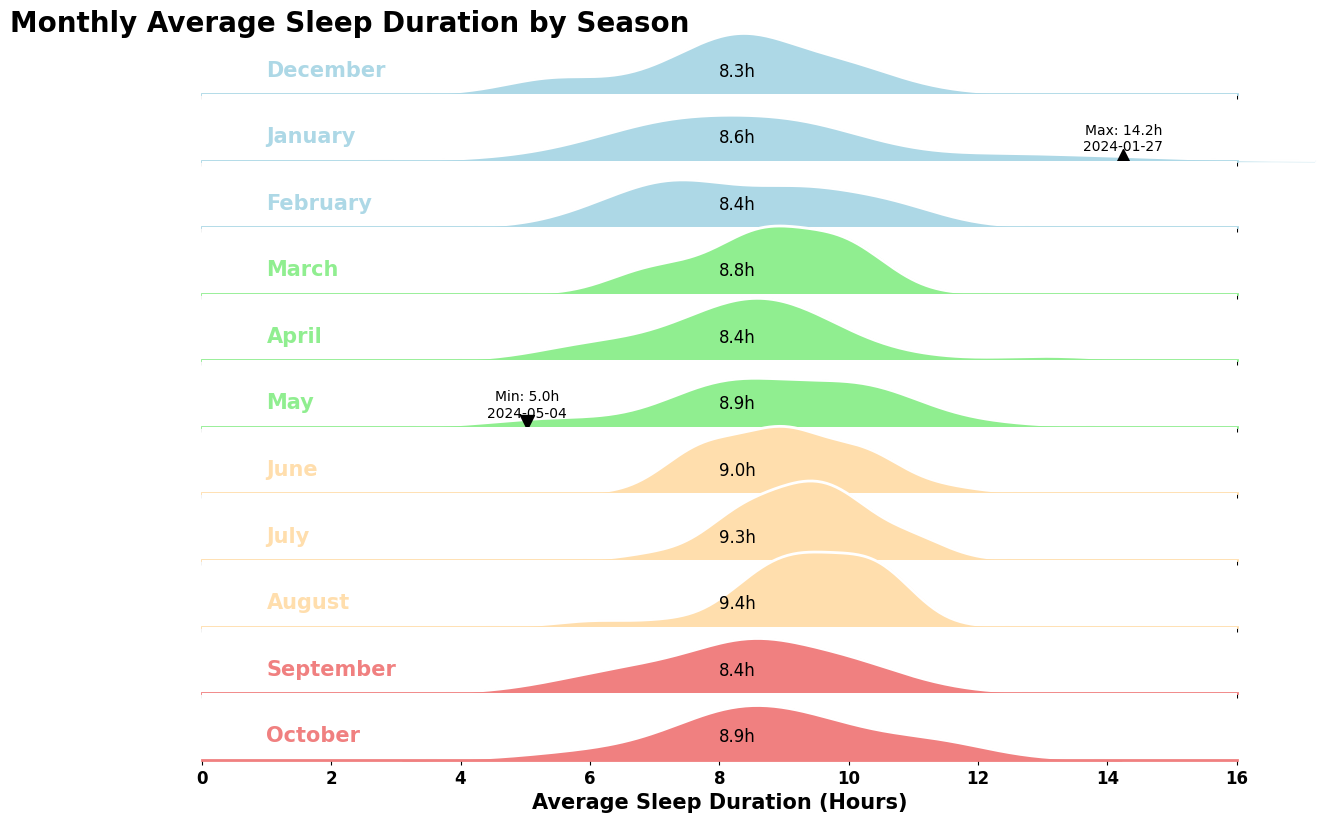

In [365]:
sleep_df['date'] = pd.to_datetime(sleep_df['date'])
filtered_sleep_df = sleep_df[sleep_df['date'] >= pd.Timestamp('2023-06-01')].copy()
filtered_sleep_df.loc[:, 'month'] = filtered_sleep_df['date'].dt.month
filtered_sleep_df.loc[:, 'month_name'] = filtered_sleep_df['date'].dt.strftime('%B')
month_avg_sleep = filtered_sleep_df.groupby('month_name')['sleep_duration'].mean()

overall_min_idx = filtered_sleep_df['sleep_duration'].idxmin()
overall_max_idx = filtered_sleep_df['sleep_duration'].idxmax()
overall_min = filtered_sleep_df.loc[overall_min_idx]
overall_max = filtered_sleep_df.loc[overall_max_idx]

valid_months = filtered_sleep_df['month'].value_counts()[filtered_sleep_df['month'].value_counts() > 1].index
valid_data = filtered_sleep_df[filtered_sleep_df['month'].isin(valid_months)]

season_colors = {
    'Spring': 'lightgreen',
    'Summer': 'navajowhite',
    'Autumn': 'lightcoral',
    'Winter': 'lightblue'
}

month_to_season = {
    'January': 'Winter', 'February': 'Winter', 'March': 'Spring',
    'April': 'Spring', 'May': 'Spring', 'June': 'Summer',
    'July': 'Summer', 'August': 'Summer', 'September': 'Autumn',
    'October': 'Autumn', 'November': 'Autumn', 'December': 'Winter'
}

month_palette = {month: season_colors[season] for month, season in month_to_season.items()}

g = sns.FacetGrid(valid_data, row='month_name', hue='month_name', aspect=15, height=0.75, palette=month_palette, row_order=valid_data['month_name'].unique())
g.map(sns.kdeplot, 'sleep_duration', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'sleep_duration', bw_adjust=1, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    month_name = valid_data['month_name'].unique()[i]
    avg_sleep = month_avg_sleep[month_name]
    
    if month_name == overall_min['month_name']:
        ax.scatter(overall_min['sleep_duration'], 0.02, color='black', s=100, zorder=5, marker='v')
        ax.text(overall_min['sleep_duration'], 0.03, 
                f'Min: {overall_min["sleep_duration"]:.1f}h\n{overall_min["date"].strftime("%Y-%m-%d")}', 
                ha='center', va='bottom', color='black', fontweight='regular')
    
    if month_name == overall_max['month_name']:
        ax.scatter(overall_max['sleep_duration'], 0.02, color='black', s=100, zorder=5, marker='^')
        ax.text(overall_max['sleep_duration'], 0.03, 
                f'Max: {overall_max["sleep_duration"]:.1f}h\n{overall_max["date"].strftime("%Y-%m-%d")}', 
                ha='center', va='bottom', color='black', fontweight='regular')
        
    ax.text(8, 0.08, f'{avg_sleep:.1f}h', fontsize=12, color='black', fontweight='regular')
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 0.3)
    ax.text(1, 0.08, month_name, fontweight='bold', fontsize=15, color=ax.lines[-1].get_color())

g.fig.subplots_adjust(hspace=0)
g.set_titles("")
g.set(yticks=[], ylabel=None)
g.despine(bottom=True, left=True)
plt.setp(g.axes.flat[-1].get_xticklabels(), fontsize=12, fontweight='bold')
plt.xlabel('Average Sleep Duration (Hours)', fontweight='bold', fontsize=15)
g.fig.suptitle('Monthly Average Sleep Duration by Season',
               ha='right',
               fontsize=20,
               fontweight='bold')
plt.show()


The visualization shows seasonal patterns in sleep duration, the peek of sleep duration of 14.2 hours occurred on June 17, 2023, right after completing a highly significant NMT test essential for university admissions. CAnd the shortest sleep duration of 5.0 hours in May 2024 aligns with a period of intensive coding work in assembly language, where late-night efforts were required to meet deadlines.

Winter shows longer sleep durations, reflecting less academic pressure during January break. In contrast, autumn, coinciding with the start of a new academic semester, has shorter and more irregular sleep patterns. Similarly, summer months (July and August), which align with vacation periods, display moderate sleep durations, possibly due to a relaxed schedule compared to the structured demands of the academic year. 
So my sleep duration is closely influenced by academic schedules and seasonal variations in personal routines.

How do massive strikes affect my sleep? What about exams and tests?

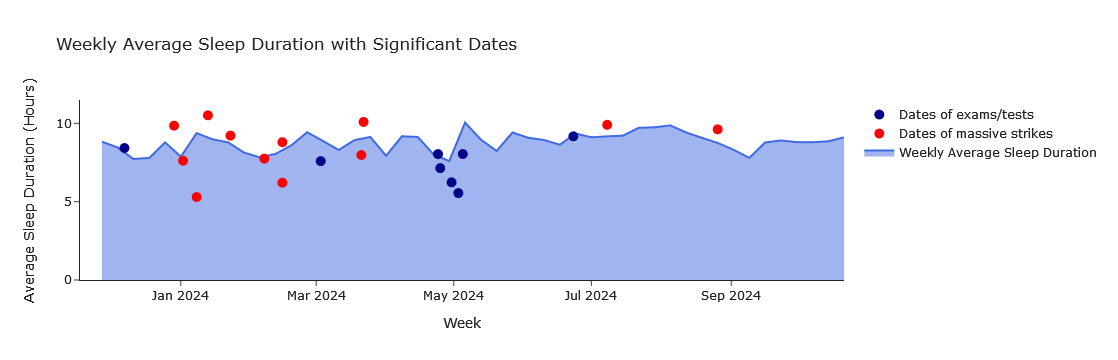

In [298]:
import plotly.graph_objects as go

sleep_df = sleep_df[sleep_df['date'] >= pd.Timestamp('2023-12-01')].copy()

sleep_df['date'] = pd.to_datetime(sleep_df['date'])
sleep_df = sleep_df.sort_values(by='date')

sleep_df['week'] = sleep_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_avg_sleep = sleep_df.groupby('week')['sleep_duration'].mean().reset_index()

key_dates = [
    "2022-02-24", "2022-10-10", "2022-10-22", "2022-10-31", "2022-11-15", "2022-11-23",
    "2022-12-05", "2022-12-16", "2022-12-29", "2022-12-31", "2023-01-14", "2023-01-26",
    "2023-02-10", "2023-02-16", "2023-03-09", "2023-12-29", "2024-01-02", "2024-01-08",
    "2024-01-13", "2024-01-23", "2024-02-07", "2024-02-15", "2024-03-21", "2024-03-22",
    "2024-07-08", "2024-08-26"
]

dates_of_exams = [
    "2023-12-12", "2024-03-03", "2024-04-30", "2024-04-24", "2024-05-05", "2024-04-25",
    "2024-05-03", "2023-12-07", "2024-06-23", "2024-06-26",
]

key_dates = pd.to_datetime(key_dates)
dates_of_exams = pd.to_datetime(dates_of_exams)

event_sleep_data = sleep_df[sleep_df['date'].isin(key_dates)]
exam_sleep_data = sleep_df[sleep_df['date'].isin(dates_of_exams)]

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=weekly_avg_sleep['week'],
        y=weekly_avg_sleep['sleep_duration'],
        mode='lines',
        name='Weekly Average Sleep Duration',
        line=dict(color='royalblue'),
        fill='tonexty'
    )
)

fig.add_trace(
    go.Scatter(
        x=event_sleep_data['date'],
        y=event_sleep_data['sleep_duration'],
        mode='markers+text',
        name='Dates of massive strikes',
        textposition='top center',
        marker=dict(color='red', size=10)
    )
)

fig.add_trace(
    go.Scatter(
        x=exam_sleep_data['date'],
        y=exam_sleep_data['sleep_duration'],
        mode='markers+text',
        name='Dates of exams/tests',
        textposition='top center',
        marker=dict(color='darkblue', size=10)
    )
)

fig.update_layout(
    title='Weekly Average Sleep Duration with Significant Dates',
    xaxis_title='Week',
    yaxis_title='Average Sleep Duration (Hours)',
    showlegend=True,
    template='simple_white',
    height=500
)

fig.show()


The graphic shows that on exam/test days, I tend to sleep less comparing to my avarage sleep duration during the week, likely due to preparation and stress. And some days of massive strikes also affected my sleep, as I have to wake up during night.

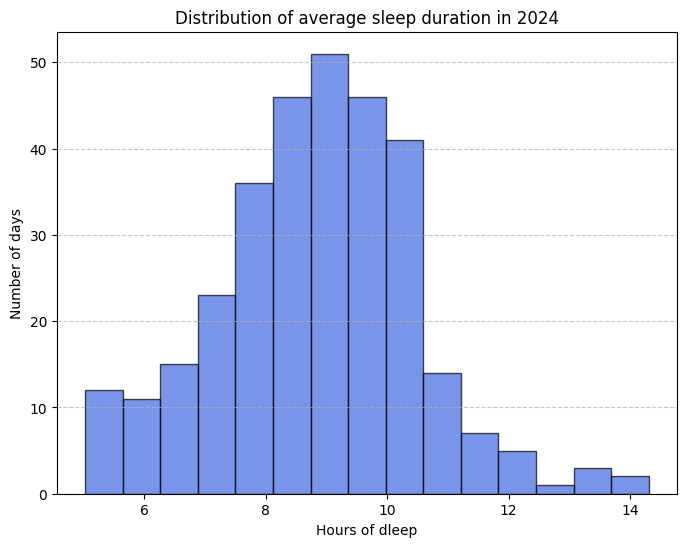

In [34]:
sleep_2024 = sleep_df[sleep_df['year'] == 2024]

plt.figure(figsize=(8, 6))

plt.hist(sleep_2024['sleep_duration'], bins=15, color='royalblue', alpha=0.7, edgecolor='black')

plt.title('Distribution of average sleep duration in 2024')
plt.xlabel('Hours of sleep')
plt.ylabel('Number of days')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Average time I go to sleep per year:
   year sleep_time
0  2022      22:01
1  2023      23:14
2  2024      23:51


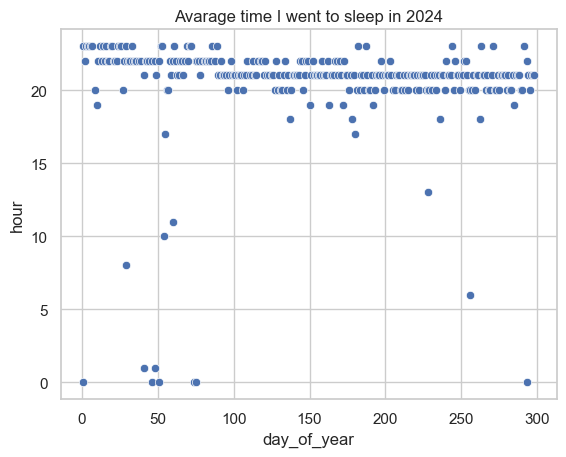

In [45]:
sns.set(style="whitegrid")
sleep_times = []

for i in range(1, len(user_messages)):
    current_message_time = user_messages.iloc[i]['date']
    previous_message_time = user_messages.iloc[i - 1]['date']
    
    time_difference = (current_message_time - previous_message_time).total_seconds() / 3600
    
    if 6 < time_difference <= 15:
        sleep_times.append({'date': previous_message_time.date(), 'sleep_time': previous_message_time.time()})

sleep_times_df = pd.DataFrame(sleep_times)
sleep_times_df['year'] = pd.to_datetime(sleep_times_df['date']).dt.year

sleep_times_df.head()
def average_time(series):
    total_minutes = series.apply(lambda x: (x.hour + 3) * 60 + x.minute).mean()  # adding +3hours as in kyiv UTC+3
    average_hour = int(total_minutes // 60) % 24
    average_minute = int(total_minutes % 60)
    return f"{average_hour:02d}:{average_minute:02d}"

average_sleep_time_per_year = sleep_times_df.groupby('year')['sleep_time'].apply(average_time).reset_index()

print("Average time I go to sleep per year:")
print(average_sleep_time_per_year)

average_sleep_time_2024 = average_sleep_time_per_year[average_sleep_time_per_year['year'] == 2024]

sleep_times_2024 = sleep_times_df[sleep_times_df['year'] == 2024].copy()
sleep_times_2024['day_of_year'] = pd.to_datetime(sleep_times_2024['date']).dt.day_of_year
sleep_times_2024['hour'] = sleep_times_2024['sleep_time'].apply(lambda x: x.hour if x else None)  # Adjust for Kyiv time (UTC+3)

sns.scatterplot(data=sleep_times_2024, x='day_of_year', y='hour', marker='o')
plt.title("Avarage time I went to sleep in 2024")
plt.show()

sleep_times_df['day_of_year'] = pd.to_datetime(sleep_times_df['date']).dt.day_of_year
sleep_times_df['hour'] = sleep_times_df['sleep_time'].apply(lambda x: x.hour if x else None)

In the beginning of the year, I tended to go to sleep slightly later compared to the rest of the year. Over time, my sleeping schedule became more consistent, with most days showing a bedtime between 10pm and midnight.

2. How does the number of sent messages change throughout the week (breakdown by days of the week)?

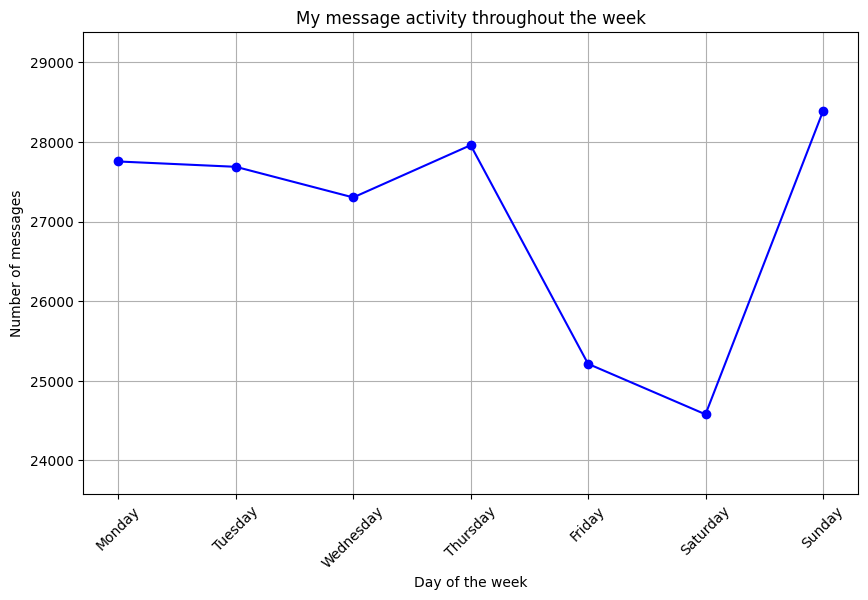

In [21]:
my_messages = df_copy.loc[df_copy['from_id'] == my_tg_id].copy()
my_messages['day_of_week'] = my_messages['date'].dt.dayofweek

messages_per_day = my_messages.groupby('day_of_week').size()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
messages_per_day.index = days

plt.figure(figsize=(10, 6))
messages_per_day.plot(kind='line', marker='o', color='blue')
plt.title('My message activity throughout the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of messages')
plt.ylim(messages_per_day.min() - 1000, messages_per_day.max() + 1000)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The most active day in terms of activity is Sunday, while the day I am least active is Saturday(probably resting after long week).

3. What is the message activity throughout the day? At what time of day am I most active?

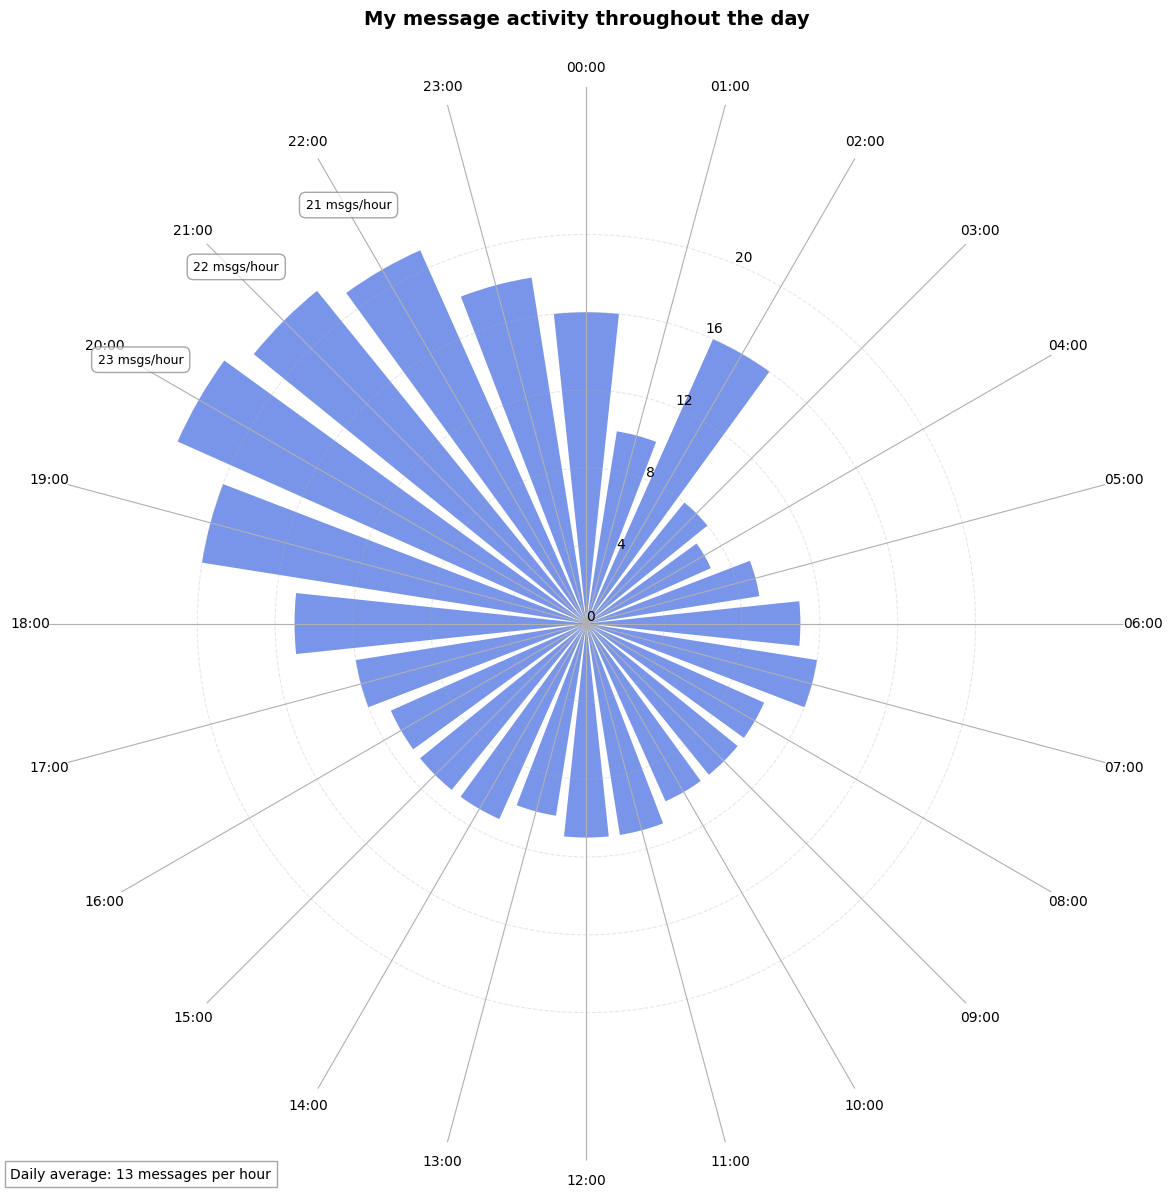

In [331]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

my_messages = df_copy[df_copy['from_id'] == my_tg_id].copy()

my_messages['date'] = pd.to_datetime(my_messages['date'], errors='coerce')
my_messages['date'] = my_messages['date'].dt.tz_convert(None)

my_messages.loc[:, 'hour'] = my_messages['date'].dt.hour
my_messages.loc[:, 'date'] = my_messages['date'].dt.date.astype('datetime64[ns]')

messages_per_day_hour = my_messages.groupby(['date', 'hour']).size().reset_index()
avg_messages_per_hour = messages_per_day_hour.groupby('hour')[0].mean().round().astype(int)

def create_radial_message_plot(messages_per_hour):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='polar')
    
    hours = np.linspace(0, 2*np.pi, 24, endpoint=False)
    values = messages_per_hour.values
    width = 2*np.pi/24 * 0.8
    
    single_color = '#4169E1'

    bars = ax.bar(hours, values, width=width, alpha=0.7, color=single_color)
    
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    
    hour_labels = [f'{i:02d}:00' for i in range(24)]
    ax.set_xticks(hours)
    ax.set_xticklabels(hour_labels, fontsize=10)
    
    max_messages = max(values)
    ax.set_ylim(0, max_messages * 1.2)
    ax.set_rticks(np.arange(0, max_messages + 1, max(1, max_messages // 5)))
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}'))
    
    plt.title('My message activity throughout the day', y=1.05, fontsize=14, fontweight='bold')
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.spines['polar'].set_visible(False)
    
    top_3_hours = messages_per_hour.nlargest(3)
    for hour, count in top_3_hours.items():
        angle = hours[hour]
        ax.annotate(f'{int(count)} msgs/hour',
                   xy=(angle, count),
                   xytext=(angle, count + max_messages * 0.15),
                   ha='center',
                   va='bottom',
                   fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.5',
                           fc='white',
                           ec='gray',
                           alpha=0.7))
    
    # Add total daily average annotation
    daily_avg = int(values.mean())
    plt.figtext(0.02, 0.02, f'Daily average: {daily_avg} messages per hour',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
    
    plt.tight_layout()
    return fig

fig = create_radial_message_plot(avg_messages_per_hour)
plt.show()


I have observed that not only am I most active during these hours, but so are people of my age group,so my friends and followers. Knowing this, I strategically use these peak activity times to post on social media, as it ensures quicker feedback and more likes due to higher engagement during these hours.

4. Does the activity of sent and received messages change on holidays compared to regular days?

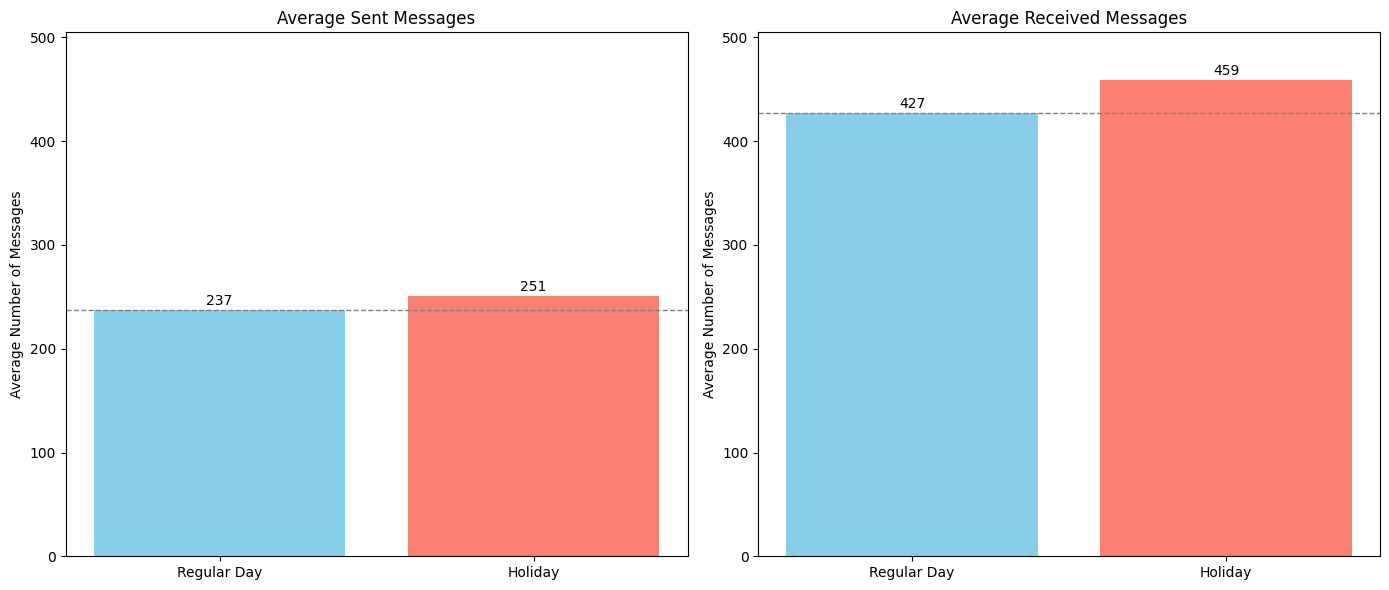

In [314]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'user_id=(\d+)')
#I took one year that I was using tg actively 
start_date = "2023-09-01"
end_date = "2024-09-01"
df_period = df_copy[(df_copy['date'] >= start_date) & (df_copy['date'] < end_date)].copy()
df_period['date'] = pd.to_datetime(df_period['date'])

holidays = [
    "2023-10-14", "2023-12-25", "2024-01-01", "2024-01-07", "2024-02-14",
    "2024-03-08", "2024-04-07", "2024-05-01", "2024-05-09", "2024-06-01",
    "2024-06-28", "2024-08-24", "2024-10-14"
]
holidays = pd.to_datetime(holidays)

df_period.loc[:, 'is_holiday'] = df_period['date'].dt.date.isin(holidays.date)
my_tg_id = *
sent_messages = df_period[df_period['from_id'] == my_tg_id]
received_messages = df_period[(df_period['dialog_id'] != my_tg_id) & 
    (~df_period['dialog_id'].astype(str).str.contains('-'))]

total_sent_holiday = sent_messages[sent_messages['is_holiday']].shape[0]
total_sent_regular = sent_messages[~sent_messages['is_holiday']].shape[0]
total_received_holiday = received_messages[received_messages['is_holiday']].shape[0]
total_received_regular = received_messages[~received_messages['is_holiday']].shape[0]

num_holiday_days = df_period[df_period['is_holiday']]['date'].dt.date.nunique()
num_regular_days = df_period[~df_period['is_holiday']]['date'].dt.date.nunique()

average_sent_holiday = int(total_sent_holiday / num_holiday_days)
average_sent_regular = int(total_sent_regular / num_regular_days)
average_received_holiday = int(total_received_holiday / num_holiday_days)
average_received_regular = int(total_received_regular / num_regular_days)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sent_data = [average_sent_regular, average_sent_holiday]
received_data = [average_received_regular, average_received_holiday]
max_value = max(max(sent_data), max(received_data))

bars1 = ax[0].bar(['Regular Day', 'Holiday'], sent_data, color=['skyblue', 'salmon'])
ax[0].axhline(y=average_sent_regular, color='gray', linestyle='--', linewidth=1)
ax[0].set_title('Average Sent Messages')
ax[0].set_ylabel('Average Number of Messages')
ax[0].set_ylim(0, max_value * 1.1)

for bar in bars1:
    height = bar.get_height()
    ax[0].text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

bars2 = ax[1].bar(['Regular Day', 'Holiday'], received_data, color=['skyblue', 'salmon'])
ax[1].axhline(y=average_received_regular, color='gray', linestyle='--', linewidth=1)
ax[1].set_title('Average Received Messages')
ax[1].set_ylabel('Average Number of Messages')
ax[1].set_ylim(0, max_value * 1.1)

for bar in bars2:
    height = bar.get_height()
    ax[1].text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()


So there are slightly more activity during holidays.

5. What is my activity in group chats compared to personal chats? (chart)

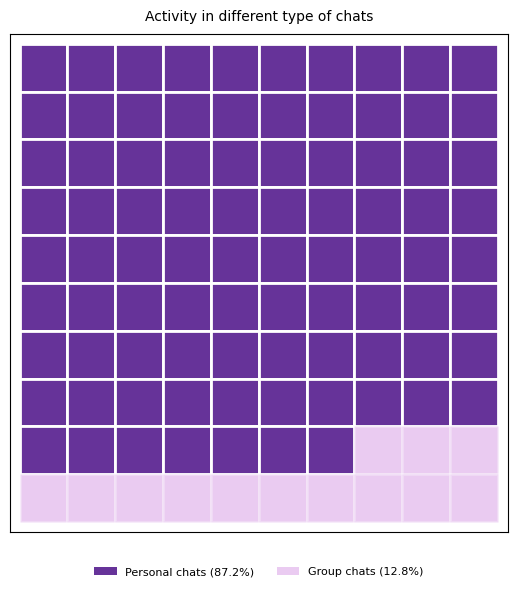

In [344]:
group_chats = df_copy[(df_copy['dialog_id'].astype(str).str.contains('-')) & (df_copy['from_id'] == my_tg_id)]
personal_chats = df_copy[~df_copy['dialog_id'].astype(str).str.contains('-') & (df_copy['from_id'] == my_tg_id)]

group_messages = group_chats.shape[0]
personal_messages = personal_chats.shape[0]
total_messages = group_messages + personal_messages

personal_percent = round((personal_messages / total_messages) * 100, 1)
group_percent = round((group_messages / total_messages) * 100, 1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, aspect='equal')

total_squares = 100
personal_squares = int((personal_messages / total_messages) * total_squares)
group_squares = total_squares - personal_squares

ax.set_xticks([])
ax.set_yticks([])

for i in range(10):
    for j in range(10):
        index = i * 10 + j
        if index < personal_squares:
            color = 'rebeccapurple'
            alpha = 1.0
        else:
            color = 'mediumorchid'
            alpha = 0.3
        ax.add_patch(plt.Rectangle((j, 9-i), 1, 1, facecolor=color, 
                                 edgecolor='white', alpha=alpha, linewidth=2))

ax.set_xlim(-0.2, 10.2)
ax.set_ylim(-0.2, 10.2)

plt.title('Activity in different type of chats', pad=10, fontsize=10)

legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor='rebeccapurple', alpha=1.0, 
                 label=f'Personal chats ({personal_percent}%)'),
    plt.Rectangle((0, 0), 1, 1, facecolor='mediumorchid', alpha=0.3, 
                 label=f'Group chats ({group_percent}%)')
]
ax.legend(handles=legend_elements, loc='upper center', 
         bbox_to_anchor=(0.5, -0.05), frameon=False, fontsize=8,
         ncol=2)

plt.tight_layout()
plt.show()

So I text a lot more in private chats than group chats.

6. When students start to mention exams in our faculty chat "ФІ"?

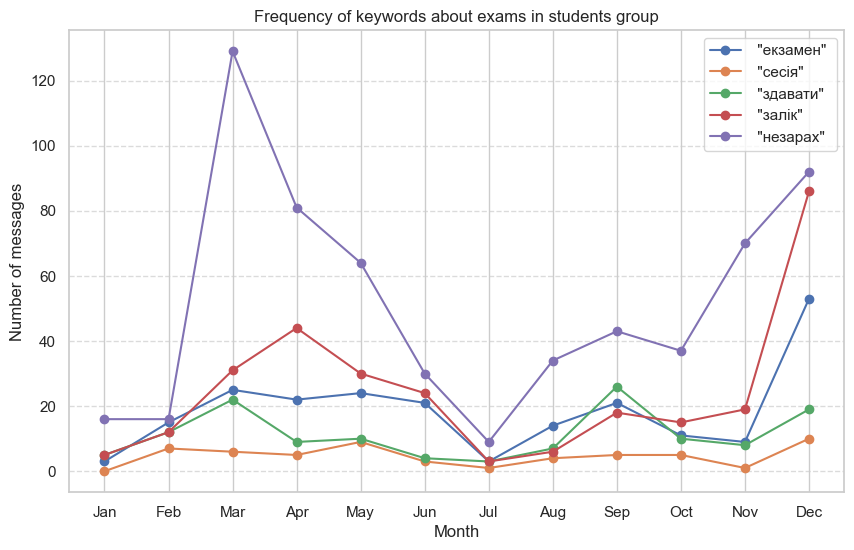

In [84]:
keywords = ["екзамен", "сесія", "здавати", "залік", "незарах"]

df_copy = df.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')
df_copy = df_copy[df_copy['dialog_id'] == -1001142723513]

df_copy['month'] = df_copy['date'].dt.month

monthly_counts = {word: [] for word in keywords}

for word in keywords:
    monthly_data = df_copy[df_copy['message'].str.contains(word, case=False, na=False)]
    monthly_count = monthly_data.groupby('month').size()
    monthly_counts[word] = monthly_count.reindex(range(1, 13), fill_value=0) 

plt.figure(figsize=(10, 6))
for word, counts in monthly_counts.items():
    plt.plot(counts.index, counts.values, marker='o', label=f' "{word}" ')

plt.title("Frequency of keywords about exams in students group")
plt.xlabel("Month")
plt.ylabel("Number of messages")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The data shows a noticeable trend of students becoming more active about exams close to exam periods, typically in the last moments before sessions. We can notice, there is a spike in discussions involving the word "незарах" (dismissal) right before the exam periods, indicating increased anxiety and pressure as exams approach. This pattern suggests that students often delay preparation, leading to last-minute stress. The trend of increasing activity near exam months highlights the urgency students feel as deadlines close in.

7. Top 10 popular emojis of all the time?

In [235]:
# filtering the emoji by removing neutral emojies that does not give us information,
# for example, as an '📍' that is commonly used in some channels just for visualization

def extract_emojis(text):
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'
        '\U0001F466-\U0001F487'
        '\U0001F490-\U0001F4A0'
        '\U0001F980-\U0001F9C0'
        '\U0001F400-\U0001F4A0'
        '\U0001F448-\U0001F4A4'
        '\U0001F921'
        ']+'
    )
    return emoji_pattern.findall(text)

emoji_counter = Counter()

for message in df['message']:
    if isinstance(message, str):
        emojis = extract_emojis(message)
        emoji_counter.update(emojis)

top_10_emoji = emoji_counter.most_common(10)

print("Top 10 popular emojis:", top_10_emoji)

Top 10 popular emojis: [('😭', 4590), ('🙏', 3522), ('💋', 2947), ('👉', 2829), ('😂', 2761), ('👍', 2628), ('😊', 1884), ('😳', 1650), ('😍', 1615), ('😉', 1568)]


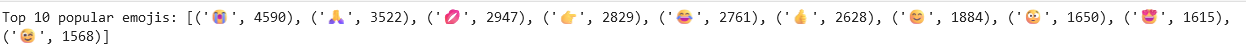

How does the popularity of emojis change over different years? (сhart for top 10 emojies for every year)

In [236]:
df_copy['year'] = pd.to_datetime(df_copy['date']).dt.year
unique_years = sorted(df_copy['year'].unique())

for idx, year in enumerate(unique_years):
    yearly_messages = df_copy[df_copy['year'] == year]['message']
    emoji_counter = Counter()
    
    for message in yearly_messages:
        if isinstance(message, str):
            emojis = extract_emojis(message)
            emoji_counter.update(emojis)
    
    top_5_emojis = emoji_counter.most_common(5)
    print(year, top_5_emojis)
    

2017 [('😂', 53), ('😅', 20), ('👍', 12), ('👌', 8), ('😂😂😂', 8)]
2018 [('😂', 114), ('👍', 57), ('😅', 47), ('😂😂😂', 31), ('😡', 26)]
2019 [('😂', 102), ('😅', 70), ('👍', 60), ('🙂', 53), ('🙏', 33)]
2020 [('😂', 253), ('👍', 177), ('😫', 86), ('😏', 71), ('😅', 69)]
2021 [('👍', 328), ('😂', 215), ('😎', 199), ('😳', 136), ('💋', 134)]
2022 [('🙏', 920), ('😂', 685), ('👍', 623), ('😊', 476), ('😳', 436)]
2023 [('💋', 1174), ('🙏', 1021), ('😭', 827), ('👉', 625), ('👥', 617)]
2024 [('😭', 3337), ('👉', 1954), ('💋', 1586), ('🙏', 1419), ('💌', 1300)]


We can see the tendency of some emojis to become less or more popular. Machine learning can be used to teach using suitable emojis for specific purposes (coping with the manner of communicating of different groups of people, such as age categories).

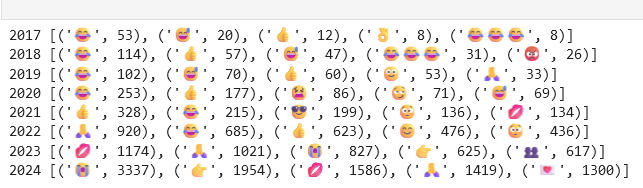

8. How often stickers are used in text messages?


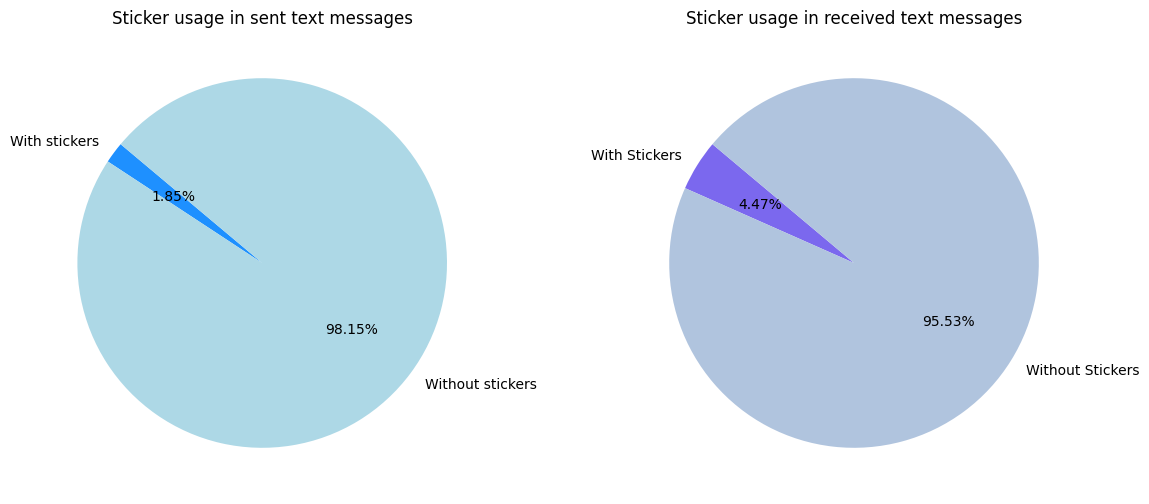

In [346]:
sent_texts = df_copy[(df_copy['from_id'] == my_tg_id) & (df_copy['type'] == 'text')]
received_texts = df_copy[(df_copy['from_id'] != my_tg_id) & (df_copy['type'] == 'text')]

def contains_sticker(text):
    sticker_pattern = re.compile(r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F]')
    return bool(sticker_pattern.search(text))

sent_texts = sent_texts.copy()
sent_texts.loc[:, 'has_sticker'] = sent_texts['message'].apply(lambda x: contains_sticker(x) if isinstance(x, str) else False)

received_texts = received_texts.copy()
received_texts.loc[:, 'has_sticker'] = received_texts['message'].apply(lambda x: contains_sticker(x) if isinstance(x, str) else False)

total_sent = sent_texts.shape[0]
sent_with_stickers = sent_texts[sent_texts['has_sticker']].shape[0]
sent_without_stickers = total_sent - sent_with_stickers

total_received = received_texts.shape[0]
received_with_stickers = received_texts[received_texts['has_sticker']].shape[0]
received_without_stickers = total_received - received_with_stickers

sent_labels = ['With stickers', 'Without stickers']
sent_counts = [sent_with_stickers, sent_without_stickers]
sent_percentages = [f'{(count / total_sent) * 100:.2f}%' for count in sent_counts]

received_labels = ['With Stickers', 'Without Stickers']
received_counts = [received_with_stickers, received_without_stickers]
received_percentages = [f'{(count / total_received) * 100:.2f}%' for count in received_counts]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pie(sent_counts, labels=sent_labels, autopct='%1.2f%%', startangle=140, colors=['dodgerblue', 'lightblue'], wedgeprops=dict(edgecolor='none'))
plt.title('Sticker usage in sent text messages')

plt.subplot(1, 2, 2)
plt.pie(received_counts, labels=received_labels, autopct='%1.2f%%', startangle=140, colors=['mediumslateblue', 'lightsteelblue'], wedgeprops=dict(edgecolor='none'))
plt.title('Sticker usage in received text messages')

plt.show()

What is the ratio of photo/video/audio messages? (sent vs received)

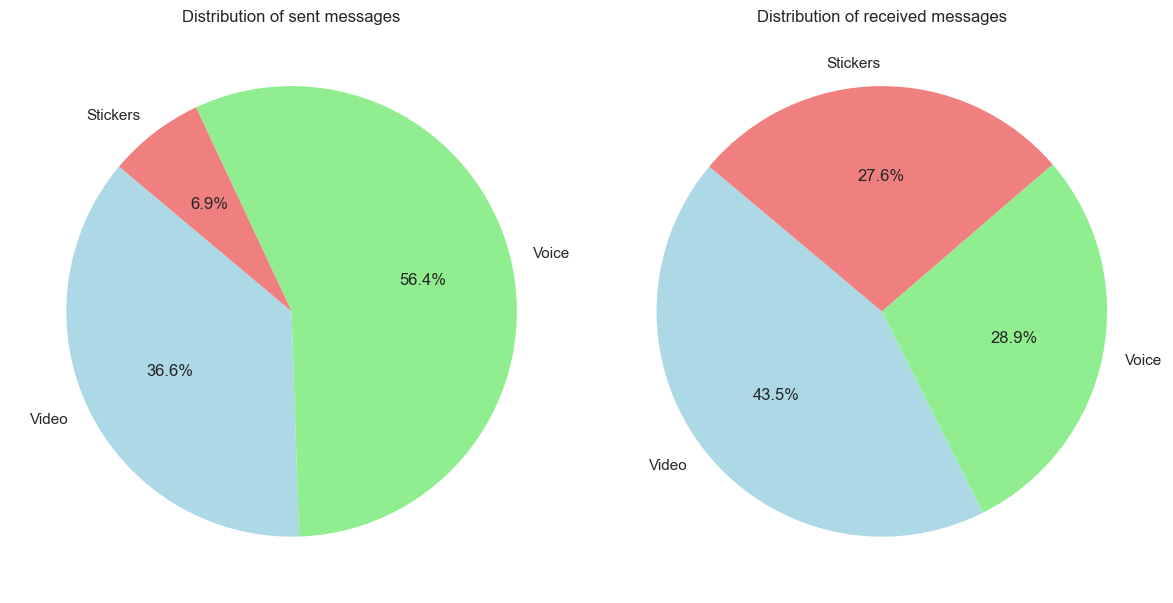

In [42]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH, low_memory=False)
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

my_tg_id = *

my_video = df_copy[(df_copy['from_id'] == my_tg_id) & (df_copy['type'] == 'video')].shape[0]
my_voice = df_copy[(df_copy['from_id'] == my_tg_id) & (df_copy['type'] == 'voice')].shape[0]
my_stickers = df_copy[(df_copy['from_id'] == my_tg_id) & (df_copy['type'] == 'sticker')].shape[0]

video = df_copy[(df_copy['from_id'] != my_tg_id) & (df_copy['type'] == 'video')].shape[0]
voice = df_copy[(df_copy['from_id'] != my_tg_id) & (df_copy['type'] == 'voice')].shape[0]
stickers = df_copy[(df_copy['from_id'] != my_tg_id) & (df_copy['type'] == 'sticker')].shape[0]

labels = ['Video', 'Voice', 'Stickers']
my_sizes = [my_video, my_voice, my_stickers]
all_sizes = [ video, voice, stickers]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(my_sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow'], wedgeprops=dict(edgecolor='none'))
axes[0].set_title('Distribution of sent messages')

axes[1].pie(all_sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow'], wedgeprops=dict(edgecolor='none'))
axes[1].set_title('Distribution of received messages')
plt.tight_layout()
plt.show()

What is used more stickers in text messages or stickers separately?

Text(0.5, 1.0, 'Distribution of sticker usage(received messages)')

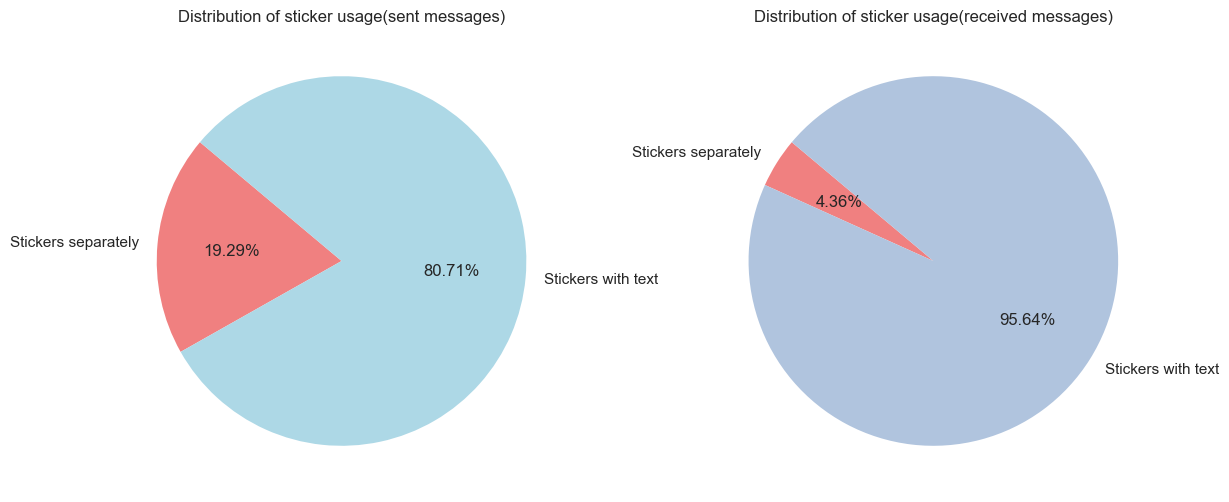

In [43]:
total_stickers_use_sent = my_stickers + sent_with_stickers
total_stickers_use_received = stickers + received_with_stickers

sent_counts = [my_stickers, sent_with_stickers]
received_counts = [stickers, received_with_stickers]
msg_labels = ['Stickers separately', 'Stickers with text']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    sent_counts,
    labels=msg_labels,
    autopct='%1.2f%%',
    startangle=140,
    colors=['lightcoral', 'lightblue'],
    wedgeprops=dict(edgecolor='none'),
)
axes[0].set_title('Distribution of sticker usage (sent messages)')

axes[1].pie(
    received_counts,
    labels=msg_labels,
    autopct='%1.2f%%',
    startangle=140,
    colors=['lightcoral', 'lightsteelblue'],
    wedgeprops=dict(edgecolor='none'),
)
axes[1].set_title('Distribution of sticker usage (received messages)')

plt.tight_layout()
plt.show()

From this pie charts stickers are used more as a part of the text messsage that separately.

### Texts anylisis

9. How often nowadays do I use curse words? Other people?

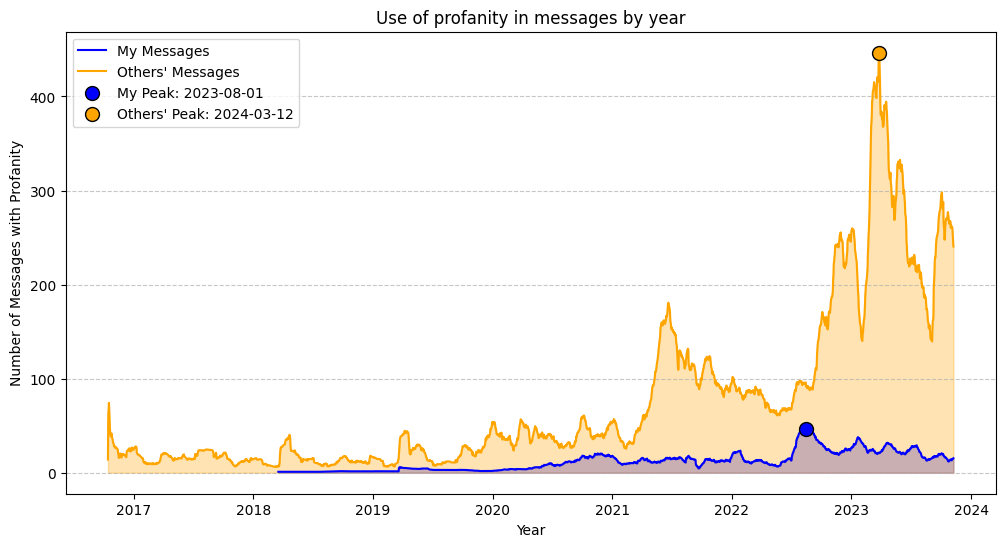

In [132]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

with open("dict/curse_words.json", "r", encoding="utf-8") as f:
    bad_words_data = json.load(f)
    bad_words = set(word.lower() for word in bad_words_data["bad_words"])

def contains_bad_words(message, bad_words):
    if pd.isna(message): 
        return False
    message = message.lower()
    return any(bad_word in message for bad_word in bad_words)

my_bad_words_messages = df_copy[df_copy['from_id'] == my_tg_id].copy()
my_bad_words_messages = my_bad_words_messages[my_bad_words_messages['message'].apply(lambda x: contains_bad_words(x, bad_words))]

others_bad_words_messages = df_copy[df_copy['from_id'] != my_tg_id].copy()
others_bad_words_messages = others_bad_words_messages[others_bad_words_messages['message'].apply(lambda x: contains_bad_words(x, bad_words))]

my_bad_words_messages['date'] = pd.to_datetime(my_bad_words_messages['date']).dt.date
others_bad_words_messages['date'] = pd.to_datetime(others_bad_words_messages['date']).dt.date

my_bad_words_daily = my_bad_words_messages.groupby('date').size()
others_bad_words_daily = others_bad_words_messages.groupby('date').size()

my_bad_words_smooth = my_bad_words_daily.rolling(window=30, min_periods=1).mean()
others_bad_words_smooth = others_bad_words_daily.rolling(window=30, min_periods=1).mean()

my_peak_date = my_bad_words_smooth.idxmax()
others_peak_date = others_bad_words_smooth.idxmax()

plt.figure(figsize=(12, 6))

plt.plot(my_bad_words_smooth.index, my_bad_words_smooth.values, color='blue', label='My Messages')
plt.fill_between(my_bad_words_smooth.index, my_bad_words_smooth.values, color='blue', alpha=0.3)

plt.plot(others_bad_words_smooth.index, others_bad_words_smooth.values, color='orange', label="Others' Messages")
plt.fill_between(others_bad_words_smooth.index, others_bad_words_smooth.values, color='orange', alpha=0.3)

# peek points
plt.scatter(my_peak_date, my_bad_words_smooth[my_peak_date], color='blue', edgecolor='black', s=100, zorder=5, label=f'My Peak: {my_peak_date}')
plt.scatter(others_peak_date, others_bad_words_smooth[others_peak_date], color='orange', edgecolor='black', s=100, zorder=5, label=f"Others' Peak: {others_peak_date}")

plt.title("Use of profanity in messages by year")
plt.xlabel("Year")
plt.ylabel("Number of Messages with Profanity")
plt.legend()

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(365))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

So, until 2019, I hadn't used any curse words in my messages. The peak of "bad words" in my messages was on August 1, 2013. In other chats, it peaked on March 2, 2024, which coincided with a massive attack on Ukraine, during which an entire apartment block in Odesa was destroyed.

10. Top 10 bi-grams for my messages and for massages sent from other people.

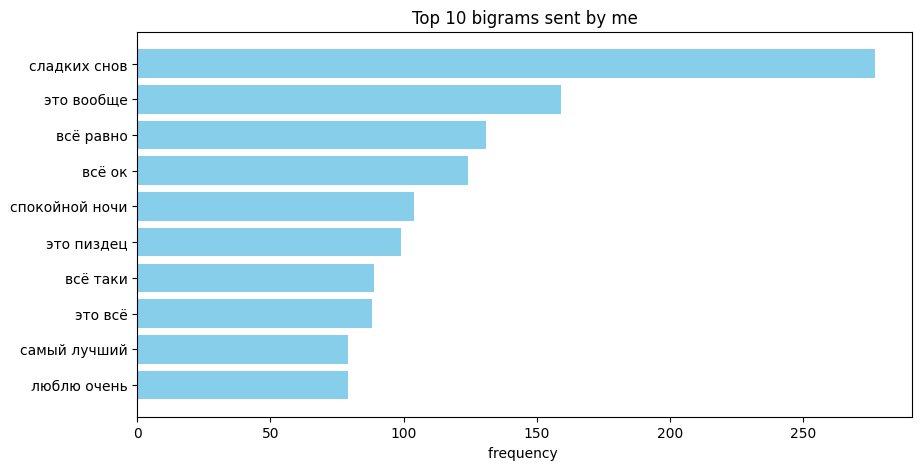

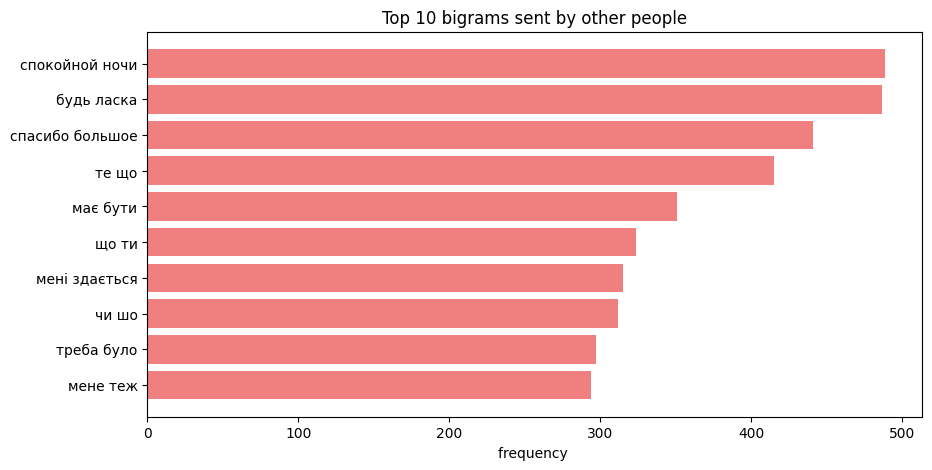

In [8]:
from nltk.util import ngrams
from nltk.corpus import stopwords

df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')
my_tg_id = *

stop_words_ru = set(stopwords.words('russian'))
stop_words_ru.update(["доброе", "женя", "це", "й", "б"])

def filter_russian(text):
    if isinstance(text, str):
        return all('\u0400' <= char <= '\u04FF' or char.isspace() for char in text)
    return False

df_copy = df_copy[df_copy['message'].apply(filter_russian)]

def extract_bigrams(df, text_col):
    bigrams = []
    for text in df[text_col].dropna():
        tokens = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words_ru]
        filtered_bigrams = [bigram for bigram in ngrams(tokens, 2) if bigram[0] != bigram[1]]
        bigrams.extend(filtered_bigrams)
    return Counter(bigrams)

my_messages = df_copy[df_copy['from_id'] == my_tg_id]
other_messages = df_copy[df_copy['from_id'] != my_tg_id]

my_bigrams = extract_bigrams(my_messages, 'message')
top_my_bigrams = my_bigrams.most_common(10)

other_bigrams = extract_bigrams(other_messages, 'message')
top_other_bigrams = other_bigrams.most_common(10)

def plot_bigrams(bigram_counts, title, color):
    bigrams, counts = zip(*bigram_counts)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 5))
    plt.barh(bigram_labels, counts, color=color)
    plt.title(title)
    plt.xlabel('frequency ')
    plt.gca().invert_yaxis()
    plt.show()

plot_bigrams(top_my_bigrams, 'Top 10 bigrams sent by me', color='skyblue')

plot_bigrams(top_other_bigrams, 'Top 10 bigrams sent by other people', color='lightcoral')

11. In which months of the year words like "buy, order" are used more often? The idea was to anilyze when people start to think about buying clothes for a new season, for example.

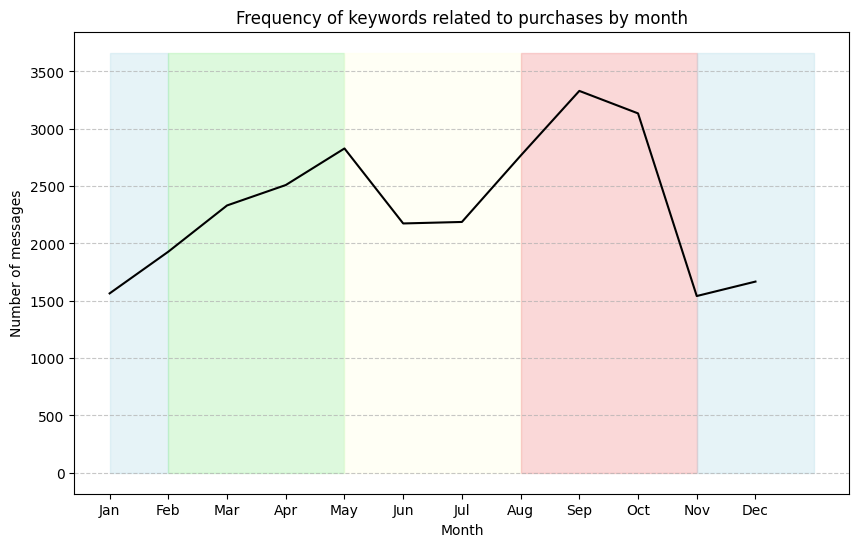

In [299]:
from matplotlib.patches import Rectangle
df_copy = df.copy()

df_copy['date'] = pd.to_datetime(df_copy['date'])
df_copy['month'] = df_copy['date'].dt.month

purchase_keywords = [
    "купити", "покупка", "замовити", "придбати", "куплю", "замовлення", "заказать", "замовиш", "замов", "замовлю", 
    "купи", "придбаю", "купить", "приобрести", "заказываю", "замовив", "замовила", "замовлюю", "оплатити",
    "обрати", "оформити", "отримати", "купував", "купувала", "замовляю", "замовляєш", "хочу купить", "хочу купити",
    "хочу заказать", "хочу замовити", 
]


def contains_purchase_keywords(message, keywords):
    if pd.isna(message):
        return False
    message = message.lower()
    return any(keyword in message for keyword in keywords)

filtered_df = df_copy[df_copy['message'].apply(lambda x: contains_purchase_keywords(x, purchase_keywords))]

purchase_by_month = filtered_df.groupby('month').size()
purchase_by_month = purchase_by_month.reindex(range(1, 13), fill_value=0)

plt.figure(figsize=(10, 6))

plt.gca().add_patch(Rectangle((1, 0), 1, max(purchase_by_month.values) * 1.1, color='lightblue', alpha=0.3, label='Winter'))
plt.gca().add_patch(Rectangle((2, 0), 3, max(purchase_by_month.values) * 1.1, color='lightgreen', alpha=0.3, label='Spring'))
plt.gca().add_patch(Rectangle((5, 0), 3, max(purchase_by_month.values) * 1.1, color='lightyellow', alpha=0.3, label='Summer'))
plt.gca().add_patch(Rectangle((8, 0), 3, max(purchase_by_month.values) * 1.1, color='lightcoral', alpha=0.3, label='Autumn'))
plt.gca().add_patch(Rectangle((11, 0), 2, max(purchase_by_month.values) * 1.1, color='lightblue', alpha=0.3, label='Winter1'))

plt.plot(purchase_by_month.index, purchase_by_month.values, color='black')
plt.title("Frequency of keywords related to purchases by month")
plt.xlabel("Month")
plt.ylabel("Number of messages")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The highest usage of purchase-related keywords occurs in May and September, which aligns with the idea that people think about buying clothes and other items during seasonal changes.

12. Are there differences in chatting/writting style (word length, character count, etc.) in different chats? What is the average message length?

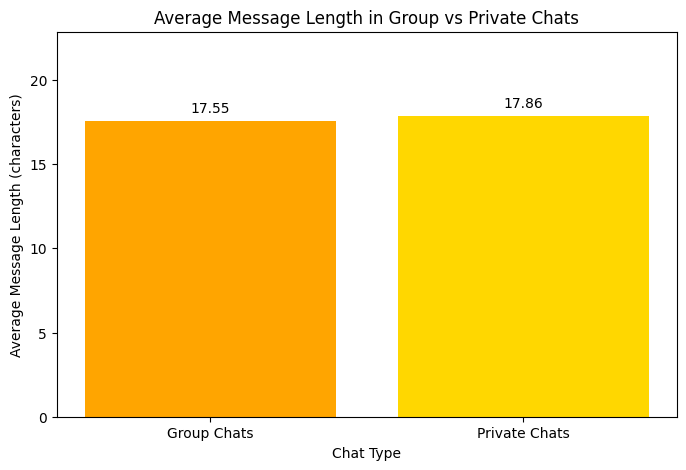

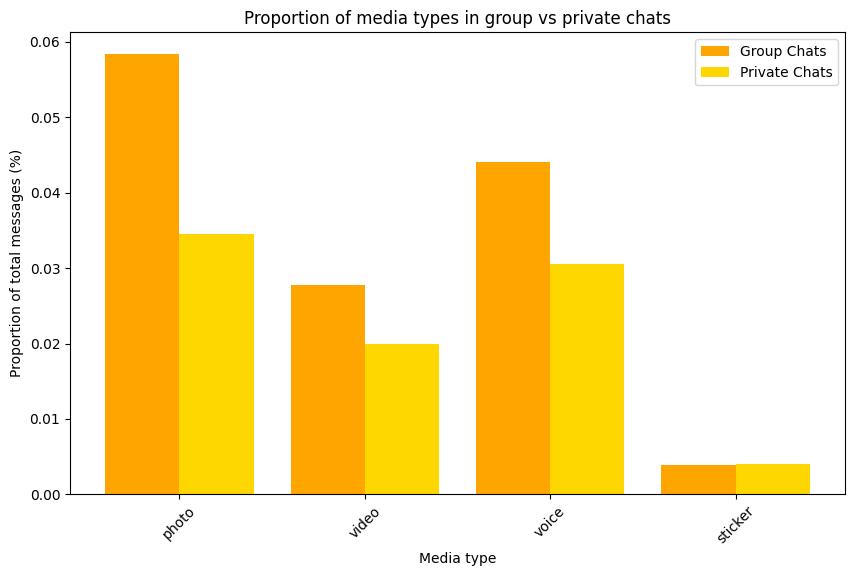

In [85]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

my_tg_id = *
group_chats = df_copy[(df_copy['dialog_id'].astype(str).str.contains('-')) & (df_copy['from_id'] == my_tg_id)].copy()
private_chats = df_copy[~df_copy['dialog_id'].astype(str).str.contains('-') & (df_copy['from_id'] == my_tg_id)].copy()

group_chats['message_length'] = group_chats['message'].str.len().fillna(0)
private_chats['message_length'] = private_chats['message'].str.len().fillna(0)

average_lengths = {
    "Group chats": group_chats['message_length'].mean(),
    "Private hats": private_chats['message_length'].mean()
}

media_types = ['photo', 'video', 'voice', 'sticker']
group_media_avg = [group_chats[group_chats['type'] == media].shape[0] / group_chats.shape[0] for media in media_types]
private_media_avg = [private_chats[private_chats['type'] == media].shape[0] / private_chats.shape[0] for media in media_types]

plt.figure(figsize=(8, 5))
bars = plt.bar(average_lengths.keys(), average_lengths.values(), color=['orange', 'gold'])
plt.title('Average Message Length in Group vs Private Chats')
plt.xlabel('Chat Type')
plt.ylabel('Average Message Length (characters)')
plt.ylim(0, max(average_lengths.values()) + 5)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{bar.get_height():.2f}", ha='center')

plt.show()

x = range(len(media_types))
plt.figure(figsize=(10, 6))
plt.bar(x, group_media_avg, width=0.4, label='Group Chats', color='orange', align='center')
plt.bar([p + 0.4 for p in x], private_media_avg, width=0.4, label='Private Chats', color='gold', align='center')
plt.xticks([p + 0.2 for p in x], media_types, rotation=45)
plt.title('Proportion of media types in group vs private chats')
plt.xlabel('Media type')
plt.ylabel('Proportion of total messages (%)')
plt.legend()
plt.show()

So actually there is a difference in my chatting style, I tend to text more i personal chats and share more media in group chats.

13. Top 3 messages that was forwarded in each dialog? Top 3 users whose messages were forwarded?

In [85]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

df_copy['is_forwarded'] = df_copy['fwd_from'].notnull()
print(df_copy.shape)
forwarded_messages = df_copy[df_copy['is_forwarded']]
forwarded_count_per_dialog = df_copy[df_copy['is_forwarded']].groupby('dialog_id').size().sort_values(ascending=False)

print("Count of forwarded messages per dialog:")
print(forwarded_count_per_dialog.head(10))

df_copy['forward_count'] = 0

forwarded_messages = df_copy[df_copy['fwd_from'].notnull()]

forwarded_counts = forwarded_messages['fwd_from'].value_counts()

df_copy.loc[df_copy['fwd_from'].notnull(), 'forward_count'] = df_copy['fwd_from'].map(forwarded_counts)
df_copy = df_copy.drop_duplicates(subset='fwd_from', keep='first')

most_forwarded_message = df_copy.sort_values(by='forward_count', ascending=False).head(1)

print("\nThe most forwarded message:")
print(most_forwarded_message[['dialog_id', 'message', 'forward_count']])

forwarded_messages['forward_count'] = 1
forwarded_messages = df_copy[(df_copy['fwd_from'].notnull()) & (df_copy['from_id'] != my_tg_id)]
user_forward_count = forwarded_messages.groupby('from_id')['forward_count'].sum().sort_values(ascending=False)

top_3_users = user_forward_count.head(3).reset_index()

df_meta_copy = df_meta.explode('users')
df_meta_copy['user_id'] = df_meta_copy['users'].str.extract(r"'user_id': (\d+)")
df_meta_copy['user_name'] = df_meta_copy['users'].str.extract(r"'first_name': '([^']+)'")

top_3_users = pd.merge(top_3_users, df_meta_copy[['user_id', 'user_name']].drop_duplicates(), left_on='from_id', right_on='user_id', how='left')

print("\nTop 3 users whose messages were forwarded the most:")
print(top_3_users[['from_id', 'user_name', 'forward_count']])

(1694041, 10)
Count of forwarded messages per dialog:
dialog_id
-1001763936745    7079
-1001142723513    6162
-1002009610217    5690
-1001790928613    4566
-1001648695212    4082
 857650813        2166
-1001806752179    2037
-1002080013117    1413
 797970730        1164
 543829731        1004
dtype: int64

The most forwarded message:
            dialog_id message  forward_count
403166 -1001648695212     NaN            325

Top 3 users whose messages were forwarded the most:
      from_id  user_name  forward_count
0   442570824  веронічка           1876
1   637919699       таня           1347
2  1328874974  Крокодиль            928


This analysis helps us see which chats have the most shared messages and identifies the users whose messages are forwarded the most. This can show who the most active or influential people are in the group.

14. Which type of media content(video, voice, picture) are the most forwarded?

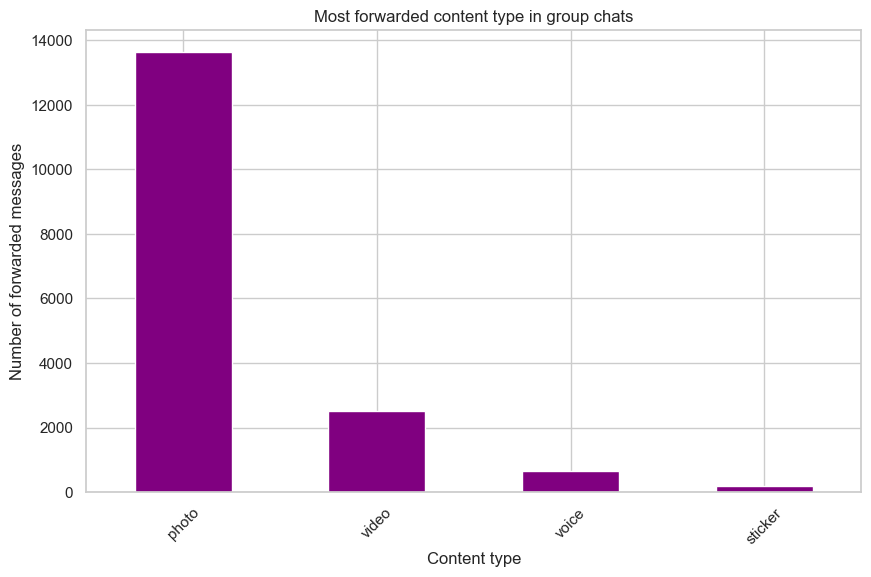

In [52]:
forwarded_messages = df_copy[(df_copy['is_forwarded']) & (df_copy['type'] != 'text')]
forwarded_type_count = forwarded_messages['type'].value_counts()

plt.figure(figsize=(10, 6))
forwarded_type_count.plot(kind='bar', color='purple')
plt.title('Most forwarded content type in group chats')
plt.xlabel('Content type')
plt.ylabel('Number of forwarded messages')
plt.xticks(rotation=45)
plt.show()

15. Top 10 bigrams that are used at night/in the afternoon?

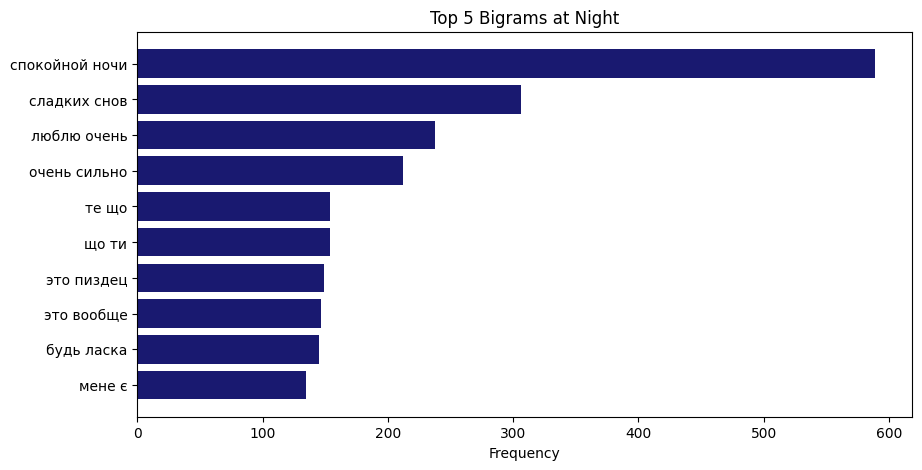

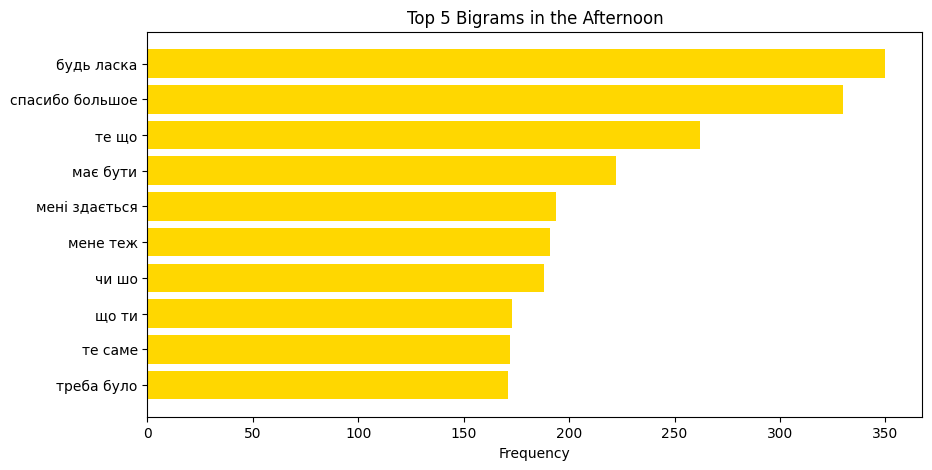

In [9]:
df_copy = df.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'])

stop_words_ru.update(["це"])

def time_of_day(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 18:
        return 'afternoon'
    else:
        return 'night'

df_copy['time_of_day'] = df_copy['date'].dt.hour.apply(time_of_day)

df_copy = df_copy[df_copy['message'].apply(filter_russian)]

def extract_bigrams(df, text_col):
    bigrams = []
    for text in df[text_col].dropna():
        tokens = [word for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words_ru]
        filtered_bigrams = [bigram for bigram in ngrams(tokens, 2) if bigram[0] != bigram[1]]
        bigrams.extend(filtered_bigrams)
    return Counter(bigrams)

night_messages = df_copy[df_copy['time_of_day'] == 'night']
afternoon_messages = df_copy[df_copy['time_of_day'] == 'afternoon']

top_night_bigrams = extract_bigrams(night_messages, 'message').most_common(10)
top_afternoon_bigrams = extract_bigrams(afternoon_messages, 'message').most_common(10)

def plot_bigrams(bigram_counts, title, color):
    bigrams, counts = zip(*bigram_counts)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 5))
    plt.barh(bigram_labels, counts, color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.show()

plot_bigrams(top_night_bigrams, 'Top 5 Bigrams at Night', color='midnightblue')
plot_bigrams(top_afternoon_bigrams, 'Top 5 Bigrams in the Afternoon', color='gold')

16. Which of my contacts share common groups with me and others? (as a graph)

In [143]:
## adding to combined data of dialogs column with dialog name
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)
df_meta_copy = df_meta.copy()
df_meta_copy = df_meta_copy[['dialog_id', 'name']]
df_meta_copy = df_meta_copy.drop_duplicates(subset='dialog_id', keep='first')
df_meta_comb = pd.merge(df_meta_comb, df_meta_copy, on='dialog_id', how='left')
print(df_meta_comb.head(3))

       dialog_id                                              users  \
0 -1002277717330  ["{'user_id': 679210513, 'first_name': 'Антон'...   
1 -1002263005176  ["{'user_id': 347624504, 'first_name': 'Настя ...   
2 -1002243068986  ["{'user_id': 387983596, 'first_name': 'Тихонр...   

           name  
0      Ковзанка  
1         be de  
2  4! БЕЗ Насті  


In [48]:
df_meta_copy = df_meta.copy()
df_meta_copy = df_meta_copy.explode('users')
df_meta_copy['user_id'] = df_meta_copy['users'].str.extract(r"'user_id': (\d+)")
df_meta_copy['user_name'] = df_meta_copy['users'].str.extract(r"'first_name': '([^']+)")

my_tg_id = *
df_meta_copy = df_meta_copy[df_meta_copy['user_id'] != my_tg_id]

user_id_counts = df_meta_copy['user_id'].value_counts()

top_5_user_ids = user_id_counts.head(10).reset_index()
top_5_user_ids.columns = ['user_id', 'count']

top_5_user_ids = pd.merge(top_5_user_ids, df_meta_copy[['user_id', 'user_name']].drop_duplicates(), on='user_id', how='left')

print("Top 5 most frequent user IDs with names:")
print(top_5_user_ids)

Top 5 most frequent user IDs with names:
      user_id  count        user_name
0   857650813     31          Никита💗
1   482979767     29           Андрей
2   701650957     22            Слава
3   959076053     21            Настя
4   347624504     21  Настя Числівник
5  1021793326     20          настюша
6   618353864     19           Milana
7   442570824     19        веронічка
8   819505183     19            анюта
9   699116823     19            Katya


17. What is the trend for the use of Ukrainian, Russian, and English? (chart for language trends throughout years)

<Figure size 1400x800 with 0 Axes>

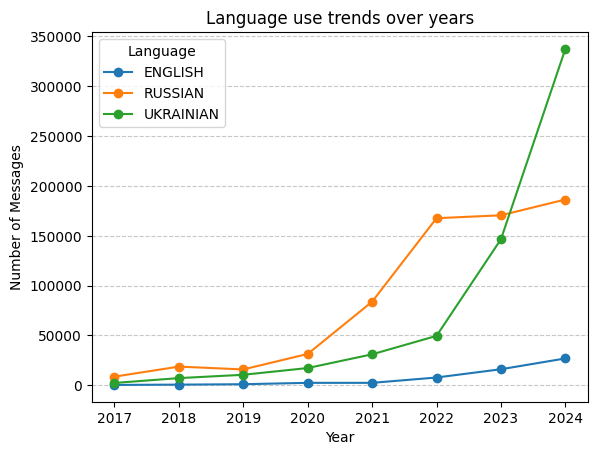

In [35]:
from lingua import LanguageDetectorBuilder, Language

languages = [Language.UKRAINIAN, Language.RUSSIAN, Language.ENGLISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

df_copy = df.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'])

def detect_language(text):
    if pd.isna(text):
        return None
    result = detector.detect_language_of(text)
    return result.name if result else None

df_copy['language'] = df_copy['message'].apply(detect_language)
df_copy['year'] = df_copy['date'].dt.year

language_counts = df_copy[df_copy['language'].isin(['UKRAINIAN', 'RUSSIAN', 'ENGLISH'])] \
    .groupby(['year', 'language']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
language_counts.plot(kind='line', marker='o')
plt.title('Language use trends over years')
plt.xlabel('Year')
plt.ylabel('Number of Messages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Language')
plt.show()

The chart shows a significant increase in the use of the Ukrainian language starting from 2021, due to the ongoing war and a shift towards national identity. English remains the least used but shows a steady, gradual increase. This indicates a cultural shift favoring Ukrainian over russian in communication.

18. What is the distribution of languages used in personal chats, small group chats, and large group chats in Telegram?

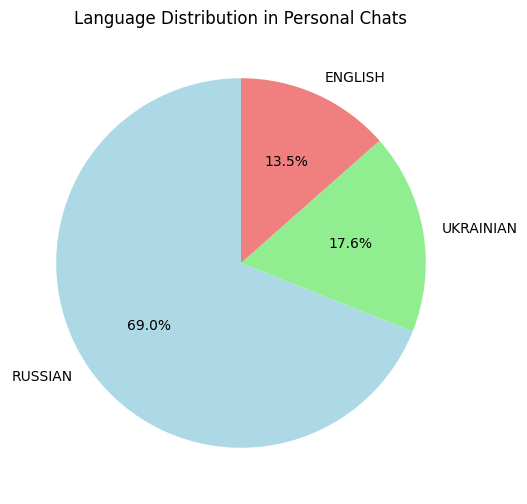

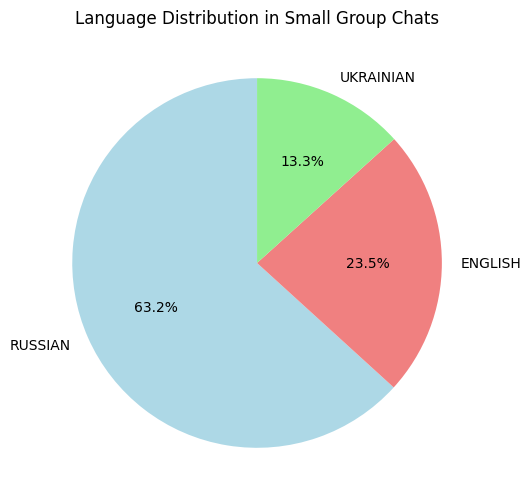

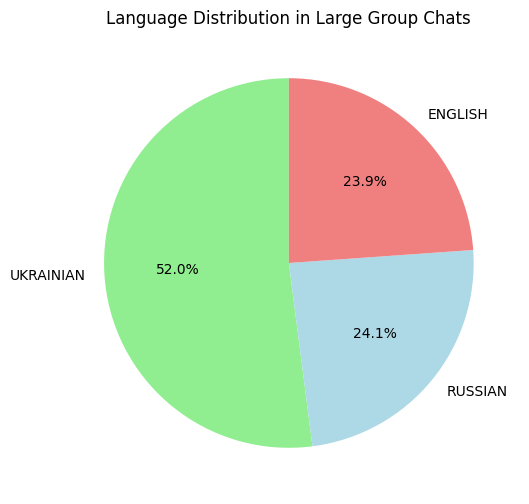

In [366]:
df_meta_comb['user_count'] = df_meta_comb['users'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

df_copy['dialog_id'] = df_copy['dialog_id'].astype(str)
small_group_chats['dialog_id'] = small_group_chats['dialog_id'].astype(str)
large_group_chats['dialog_id'] = large_group_chats['dialog_id'].astype(str)

small_group_messages = df_copy[df_copy['dialog_id'].isin(small_group_chats['dialog_id'])].copy()

large_group_messages = df_copy[df_copy['dialog_id'].isin(large_group_chats['dialog_id'])].copy()
personal_chats = df_copy[~df_copy['dialog_id'].astype(str).str.contains('-')].copy()

languages = [Language.UKRAINIAN, Language.RUSSIAN, Language.ENGLISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def detect_language(text):
    if pd.isna(text):
        return None
    result = detector.detect_language_of(text)
    return result.name if result else None

df_copy.loc[:, 'chat_type'] = 'personal'
df_copy.loc[df_copy['dialog_id'].isin(large_group_chats['dialog_id'].astype(str)), 'chat_type'] = 'large_group'
df_copy.loc[df_copy['dialog_id'].isin(small_group_chats['dialog_id'].astype(str)), 'chat_type'] = 'small_group'

personal_messages = df_copy[df_copy['chat_type'] == 'personal'].copy()
small_group_messages = df_copy[df_copy['chat_type'] == 'small_group'].copy()
large_group_messages = df_copy[df_copy['chat_type'] == 'large_group'].copy()

language_colors = {
    'UKRAINIAN': 'lightgreen',
    'RUSSIAN': 'lightblue',
    'ENGLISH': 'lightcoral'
}

for chat_type, chat_df in zip(
    ['Personal Chats', 'Small Group Chats', 'Large Group Chats'], 
    [personal_messages, small_group_messages, large_group_messages]
):
    chat_df.loc[:, 'language'] = chat_df['message'].apply(detect_language)
    language_counts = chat_df['language'].value_counts(normalize=True) * 100
    
    colors = [language_colors[lang] for lang in language_counts.index if lang in language_colors]
    
    plt.figure(figsize=(8, 6))
    plt.pie(
        language_counts, 
        labels=language_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors
    )
    plt.title(f'Language Distribution in {chat_type}')
    plt.show()


19. Which form of my name people use the most(except the basic form - Valya)?

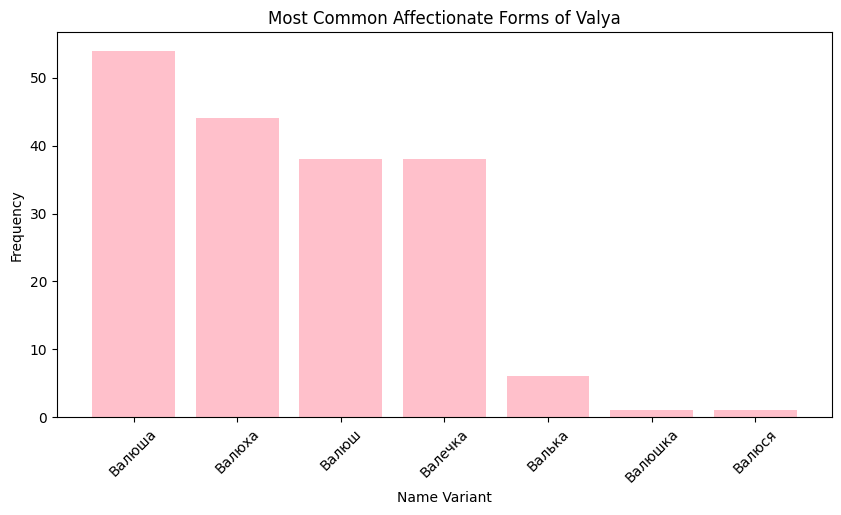

In [24]:
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')
private_chats = df_copy[~df_copy['dialog_id'].astype(str).str.contains('-')]

valya_names = [
   "Валюша", "Валюшка", "Валечка", "Валюнчик", "Валюня", "Валечка", "Валюсик", "Валюха", "Валюша",
   "Валусенька", "Валька", "Валюш", "Валюха", "Валюсічка", "Валеченька", "Валюничка", "Валенька", "Валюся"
]

def count_name_forms(messages, name_forms):
    name_counter = Counter()
    for message in messages.dropna():
        for name in name_forms:
            if name.lower() in message.lower():
                name_counter[name] += 1
    return name_counter

messages = private_chats['message']
name_counts = count_name_forms(messages, valya_names)

most_common_names = name_counts.most_common()
import matplotlib.pyplot as plt

names, counts = zip(*most_common_names)

plt.figure(figsize=(10, 5))
plt.bar(names, counts, color='pink')
plt.title('Most common forms of Valya')
plt.xlabel('Name variant')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

20. What are the top 30 most frequently shared websites in messages?

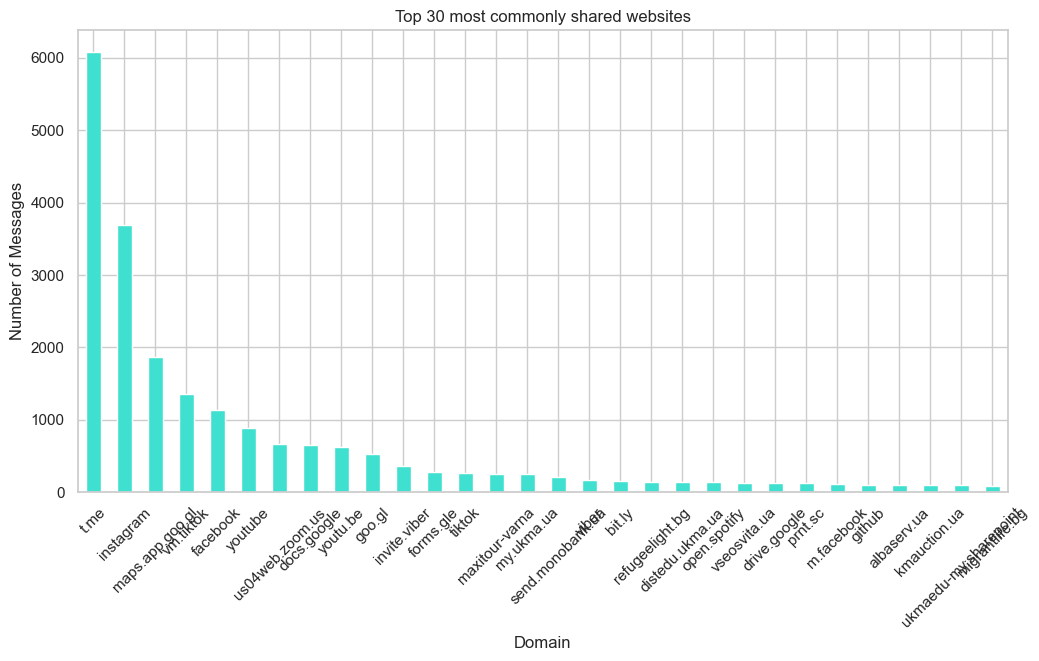

In [68]:
from urllib.parse import urlparse
df_copy = df.copy()

df_copy['message'] = df_copy['message'].astype(str)

def extract_simplified_domain(message):
    urls = re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', message)
    domains = [urlparse(url).netloc for url in urls]
    simplified_domains = [re.sub(r'www\.|(\.com|\.org|\.net|\.edu|\.gov|\.co)', '', domain) for domain in domains]
    return simplified_domains if simplified_domains else None

df_copy['domains'] = df_copy['message'].apply(extract_simplified_domain)

messages_with_domains = df_copy.dropna(subset=['domains']).explode('domains')
top_domains = messages_with_domains['domains'].value_counts().head(30)

plt.figure(figsize=(12, 6))
top_domains.plot(kind='bar', color='turquoise')
plt.title("Top 30 most commonly shared websites")
plt.xlabel("Domain")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.show()

Which categories of websites shared the most?

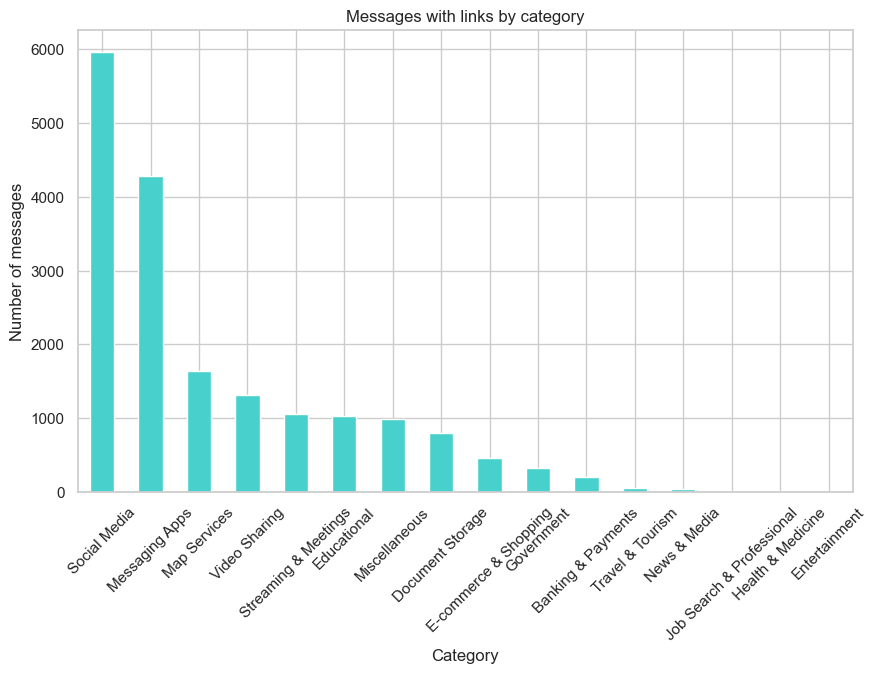

In [67]:
df_copy = df.copy()
df_copy['message'] = df_copy['message'].astype(str)

categories = {
    "Social Media": r"(instagram\.com|facebook\.com|twitter\.com|tiktok\.com|viber\.com|linkedin\.com)",
    "Video Sharing": r"(youtube\.com|youtu\.be|vimeo\.com|dailymotion\.com)",
    "Document Storage": r"(drive\.google\.com|docs\.google\.com|dropbox\.com|onedrive\.live\.com|ukmaedu-my\.sharepoint\.com)",
    "Educational": r"(naurok\.com\.ua|vseosvita\.ua|classtime\.com|dou\.ua|ukma\.edu\.ua|distedu\.ukma\.edu\.ua|osvita\.ua|edu\.ua|zno\.ua)",
    "Map Services": r"(maps\.google\.com|maps\.app\.goo\.gl|goo\.gl)",
    "Messaging Apps": r"(telegram\.org|t\.me|viber\.com|invite\.viber\.com|whatsapp\.com|messenger\.com|signal\.org|skype\.com)",
    "Banking & Payments": r"(monobank\.ua|send\.monobank\.ua|privatbank\.ua|pb\.ua|oshadbank\.ua|paypal\.com)",
    "Streaming & Meetings": r"(zoom\.us|meet\.google\.com|teams\.microsoft\.com|webex\.com|gotomeeting\.com)",
    "E-commerce & Shopping": r"(olx\.ua|olx\.bg|prom\.ua|rozetka\.com\.ua|modivo\.ua|answear\.ua|hm\.com|bershka\.com|zara\.com|aliexpress\.com|amazon\.com|ebay\.com|etsy\.com|albaserv\.com\.ua|maxitour-varna\.com|tvoyatserviz\.com|superdoc\.bg)",
    "Government": r"(petition\.president\.gov\.ua|ukraine\.gov\.bg|bulgaria\.mfa\.gov\.ua|kmu\.gov\.ua|rada\.gov\.ua|mvs\.gov\.ua|moz\.gov\.ua|mfa\.gov\.ua|gov\.ua)",
    "News & Media": r"(bbc\.com|nytimes\.com|cnn\.com|reuters\.com|forbes\.com|pravda\.com\.ua|unian\.ua|tsn\.ua|24tv\.ua|nv\.ua|bbc\.co\.uk)",
    "Health & Medicine": r"(moz\.gov\.ua|medportal\.com|apteka\.ua|tabletki\.ua|superdoc\.bg|health\.gov\.ua)",
    "Job Search & Professional": r"(work\.ua|rabota\.ua|linkedin\.com|hh\.ua|jooble\.org|careerjet\.com)",
    "Travel & Tourism": r"(booking\.com|airbnb\.com|tickets\.ua|ukrainianrailway\.com|gotoukraine\.com|hotels\.com)",
    "Entertainment": r"(netflix\.com|megogo\.net|kinopoisk\.ru|kinoua\.org|ivi\.ru|molbuk\.com|litmir\.me)",
    "Miscellaneous": r"(forms\.gle|prnt\.sc|chat\.openai\.com|g\.co|miro\.com|website1222130\.nicepage\.io|ukraine-renovation\.com|studio24\.bg|refugeelight\.bg|kmauction\.org\.ua|ukr\.net|meta\.ua)"
}

def categorize_link(message):
    for category, pattern in categories.items():
        if pd.notna(message) and re.search(pattern, message):
            return category
    return None

df_copy['link_category'] = df_copy['message'].apply(categorize_link)

messages_with_links = df_copy[df_copy['link_category'].notna()]
link_counts_by_category = messages_with_links['link_category'].value_counts()

plt.figure(figsize=(10, 6))
link_counts_by_category.plot(kind='bar', color='mediumturquoise')
plt.title("Messages with links by category")
plt.xlabel("Category")
plt.ylabel("Number of messages")
plt.xticks(rotation=45)
plt.show()

21. In which type of chat (group or privat) do I tend to ask questions more frequently?

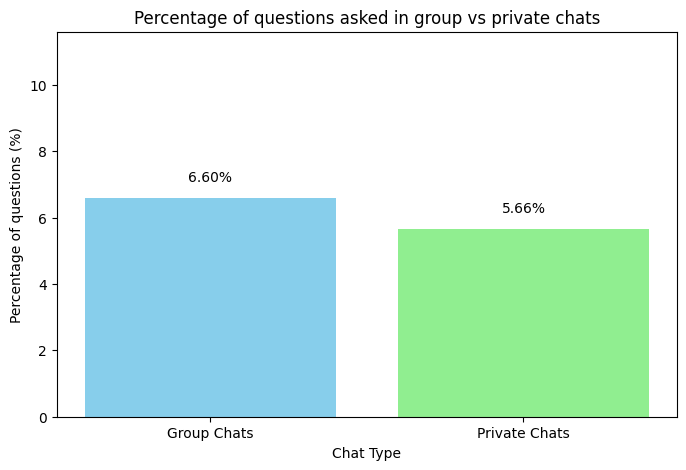

In [26]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

group_chats = df_copy[(df_copy['dialog_id'].astype(str).str.contains('-')) & (df_copy['from_id'] == my_tg_id)].copy()
private_chats = df_copy[~df_copy['dialog_id'].astype(str).str.contains('-') & (df_copy['from_id'] == my_tg_id)].copy()

def is_question(message):
    return isinstance(message, str) and message.strip().endswith('?')
    
group_question_count = group_chats['message'].apply(is_question).sum()
private_question_count = private_chats['message'].apply(is_question).sum()

total_group_messages = group_chats.shape[0]
total_private_messages = private_chats.shape[0]

group_question_percentage = (group_question_count / total_group_messages) * 100 if total_group_messages > 0 else 0
private_question_percentage = (private_question_count / total_private_messages) * 100 if total_private_messages > 0 else 0

labels = ['Group Chats', 'Private Chats']
question_percentages = [group_question_percentage, private_question_percentage]

plt.figure(figsize=(8, 5))
plt.bar(labels, question_percentages, color=['skyblue', 'lightgreen'])
for i, v in enumerate(question_percentages):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.title("Percentage of questions asked in group vs private chats")
plt.xlabel("Chat Type")
plt.ylabel("Percentage of questions (%)")
plt.ylim(0, max(question_percentages) + 5)
plt.show()

OK there is not that much difference, as i thought would be.

22. At what times of day do people tend to think about ordering food?

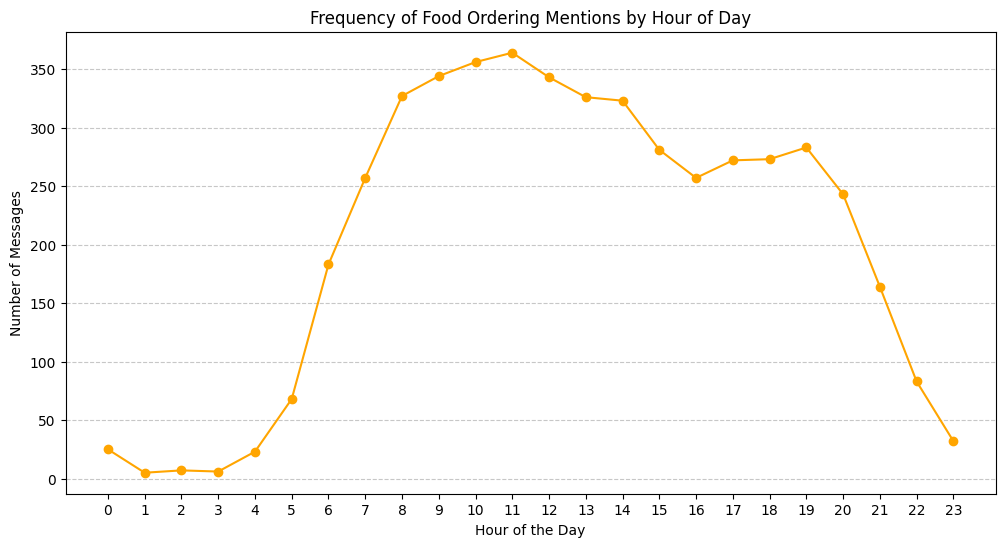

In [352]:
df_copy = df.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'], errors='coerce')

df_copy['message'] = df_copy['message'].astype(str)

keywords = [
    "замовити доставку", "доставка", "заказать доставку", 
    "glovo", "Bolt Food", "суши", "піцц", "глово", "болт фуд", 
]

def contains_food_order_keywords(message):
    return any(re.search(keyword, message, re.IGNORECASE) for keyword in keywords)

food_order_messages = df_copy[df_copy['message'].apply(contains_food_order_keywords)].copy()
food_order_messages.loc[:, 'hour'] = food_order_messages['date'].dt.hour

food_order_by_hour = food_order_messages.groupby('hour').size()

plt.figure(figsize=(12, 6))
plt.plot(food_order_by_hour.index, food_order_by_hour.values, marker='o', color='orange')
plt.title("Frequency of Food Ordering Mentions by Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Messages")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The graphic show that it happens before "meal time", as the people get hungry. More detailed research could be used for the companies that produce and deliver food.

## Sentiment analysis

23. What proportion of our messages convey neutral, positive, or negative sentiment?

In [178]:
df_copy = df.copy()
df_copy['from_id'] = df_copy['from_id'].astype(str).str.extract(r'id=(\d+)')

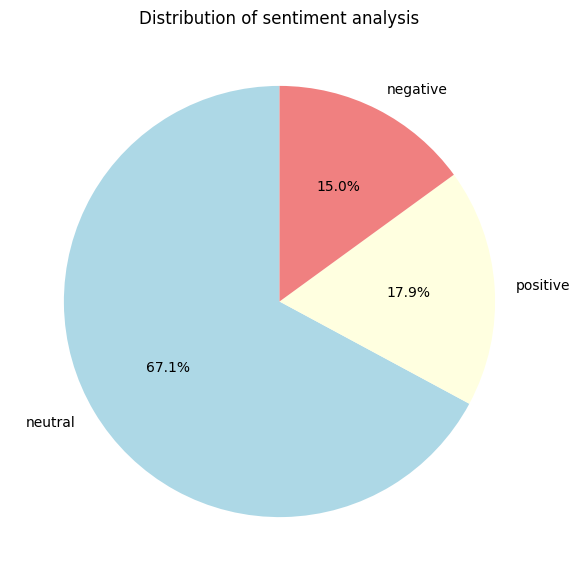

In [354]:
tone_dict_ua = pd.read_csv("tone-dict-uk-full.csv")
tone_dict_ua = tone_dict_ua.drop_duplicates(subset='word', keep='first')
tone_dict_ua = dict(zip(tone_dict_ua['word'], tone_dict_ua['sentiment']))

tone_dict_ru = pd.read_csv("tone-dict-ru.csv", sep=';')
tone_dict_ru = tone_dict_ru.drop_duplicates(subset='term', keep='first')
tone_dict_ru = dict(zip(tone_dict_ru['term'], tone_dict_ru['value']))

df_copy = df_copy[df_copy['message'].notna() & (df_copy['message'].str.strip() != '')]

with open("dicts/curse_words.json", "r", encoding="utf-8") as f:
    bad_words_data = json.load(f)
    curse_words = set(word.lower() for word in bad_words_data["bad_words"])

def get_tone(message, tone_dict, curse_words):
    words = message.split()
    sentiment_score = 0
    for word in words:
        word = word.lower()
        if word in tone_dict:
            sentiment_score += tone_dict[word]
        elif any(curse in word for curse in curse_words):
            sentiment_score += -1
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

def determine_sentiment(message, tone_dict_ua, tone_dict_ru, curse_words):
    sentiment_ua = get_tone(message, tone_dict_ua, curse_words)
    sentiment_ru = get_tone(message, tone_dict_ru, curse_words)
    return sentiment_ua if sentiment_ua else sentiment_ru
    
df_copy['sentiment'] = df_copy['message'].apply(lambda x: determine_sentiment(x, tone_dict_ua, tone_dict_ru, curse_words))
sentiment_counts = df_copy['sentiment'].value_counts()

plt.figure(figsize=(7, 7))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightyellow', 'lightcoral'])
plt.title('Distribution of sentiment analysis')
plt.ylabel('')
plt.show()


Which groups have bigger number of negative or positive sentiment messages?

In [176]:
df_copy['unique_id'] = df_copy['from_id'].combine_first(df_copy['dialog_id']).astype(str)

positive_messages = group_chats[group_chats['sentiment'] == 'positive']
negative_messages = group_chats[group_chats['sentiment'] == 'negative']

pstv_counts = positive_messages['dialog_id'].value_counts()
ngtv_counts = negative_messages['dialog_id'].value_counts()

tone_counts = pd.DataFrame({'pstv_count': pstv_counts,'ngtv_count': ngtv_counts}).fillna(0)

tone_counts['pstv_count'] = tone_counts['pstv_count'].astype(int)
tone_counts['ngtv_count'] = tone_counts['ngtv_count'].astype(int)

top_pstv_groups = tone_counts.sort_values('pstv_count', ascending=False).head(10)
top_ngtv_groups = tone_counts.sort_values('ngtv_count', ascending=False).head(10)

top_pstv_groups.reset_index(inplace=True)
top_ngtv_groups.reset_index(inplace=True)

df_meta_comb['dialog_id'] = df_meta_comb['dialog_id'].astype(str)
top_pstv_groups['dialog_id'] = top_pstv_groups['dialog_id'].astype(str)
top_ngtv_groups['dialog_id'] = top_ngtv_groups['dialog_id'].astype(str)

top_pstv_groups = top_pstv_groups.merge(
    df_meta_comb[['dialog_id', 'name']],
    on='dialog_id',
    how='left'
)

top_ngtv_groups = top_ngtv_groups.merge(
    df_meta_comb[['dialog_id', 'name']],
    on='dialog_id',
    how='left'
)

print("Top 10 groups by positive messages:")
print(top_pstv_groups[['name', 'pstv_count']])

print("\nTop 10 groups by negative messages:")
print(top_ngtv_groups[['name', 'ngtv_count']])


Top 10 Groups by Positive Messages with Names:
                               name  pstv_count
0                                ФІ       73307
1        gossip girls🎀💅🏻 and а man🫡       36397
2         Legit Community Resellers       25643
3  Пловдив Українці у Болгарії 🇺🇦🇧🇬       19309
4             Украинцы в Пловдив 🇺🇦       18715
5                          ШПРОТИKN       16277
6                      OOOM Plovdiv       14750
7          Порядок На Макариополски        5249
8     Тётя хочет решить одно дельце        3438
9                       Задоволення        2713

Top 10 Groups by Negative Messages with Names:
                               name  ngtv_count
0                                ФІ       63000
1        gossip girls🎀💅🏻 and а man🫡       29259
2             Украинцы в Пловдив 🇺🇦       21540
3  Пловдив Українці у Болгарії 🇺🇦🇧🇬       20331
4                          ШПРОТИKN       11532
5                      OOOM Plovdiv       10511
6         Legit Community Resellers      

In [177]:
total_messages = group_chats['dialog_id'].value_counts()
tone_counts['total_count'] = tone_counts.index.map(total_messages).fillna(0).astype(int)
tone_counts = tone_counts[tone_counts['total_count'] > 10000]

tone_counts['ngtv_perc'] = (tone_counts['ngtv_count'] / tone_counts['total_count']) * 100
tone_counts['pstv_perc'] = (tone_counts['pstv_count'] / tone_counts['total_count']) * 100

top_ngtv_perc = tone_counts.sort_values('ngtv_perc', ascending=False).head(10)
top_pstv_perc = tone_counts.sort_values('pstv_perc', ascending=False).head(10)

top_ngtv_perc.reset_index(inplace=True)
top_pstv_perc.reset_index(inplace=True)

top_ngtv_perc['dialog_id'] = top_ngtv_perc['dialog_id'].astype(str)
top_pstv_perc['dialog_id'] = top_pstv_perc['dialog_id'].astype(str)

top_ngtv_perc = top_ngtv_perc.merge(
    df_meta_comb[['dialog_id', 'name']],
    on='dialog_id',
    how='left'
)

top_pstv_perc = top_pstv_perc.merge(
    df_meta_comb[['dialog_id', 'name']],
    on='dialog_id',
    how='left'
)

print("Top 10 Groups by percentage of negative messages:")
print(top_ngtv_perc[['name', 'ngtv_count', 'total_count', 'ngtv_perc']])

print("\nTop 10 Groups by percentege of positive messages:")
print(top_pstv_perc[['name', 'pstv_count', 'total_count', 'pstv_perc']])

Top 10 Groups by percentage of negative messages:
                               name  ngtv_count  total_count  ngtv_perc
0             Украинцы в Пловдив 🇺🇦       21540        61713  34.903505
1  Пловдив Українці у Болгарії 🇺🇦🇧🇬       20331        61081  33.285310
2     Тётя хочет решить одно дельце        5829        20407  28.563728
3                        Не "Очев."        2279        10973  20.769161
4                          без крыс        2570        13300  19.323308
5                                ФІ       63000       348727  18.065708
6                               NaN        1817        10534  17.248908
7                      OOOM Plovdiv       10511        62967  16.692871
8                          ШПРОТИKN       11532        71197  16.197312
9        gossip girls🎀💅🏻 and а man🫡       29259       182350  16.045517

Top 10 Groups by percentege of positive messages:
                               name  pstv_count  total_count  pstv_perc
0         Legit Community Resellers

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 127872 (\N{RIBBON}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_3972\206722614.py:40: UserWarning:

Glyph 128133 (\N{NAIL POLISH}) missing from font(s) DejaVu Sans.

C:\Users\Vale\AppData\Local\Temp\ipykernel_

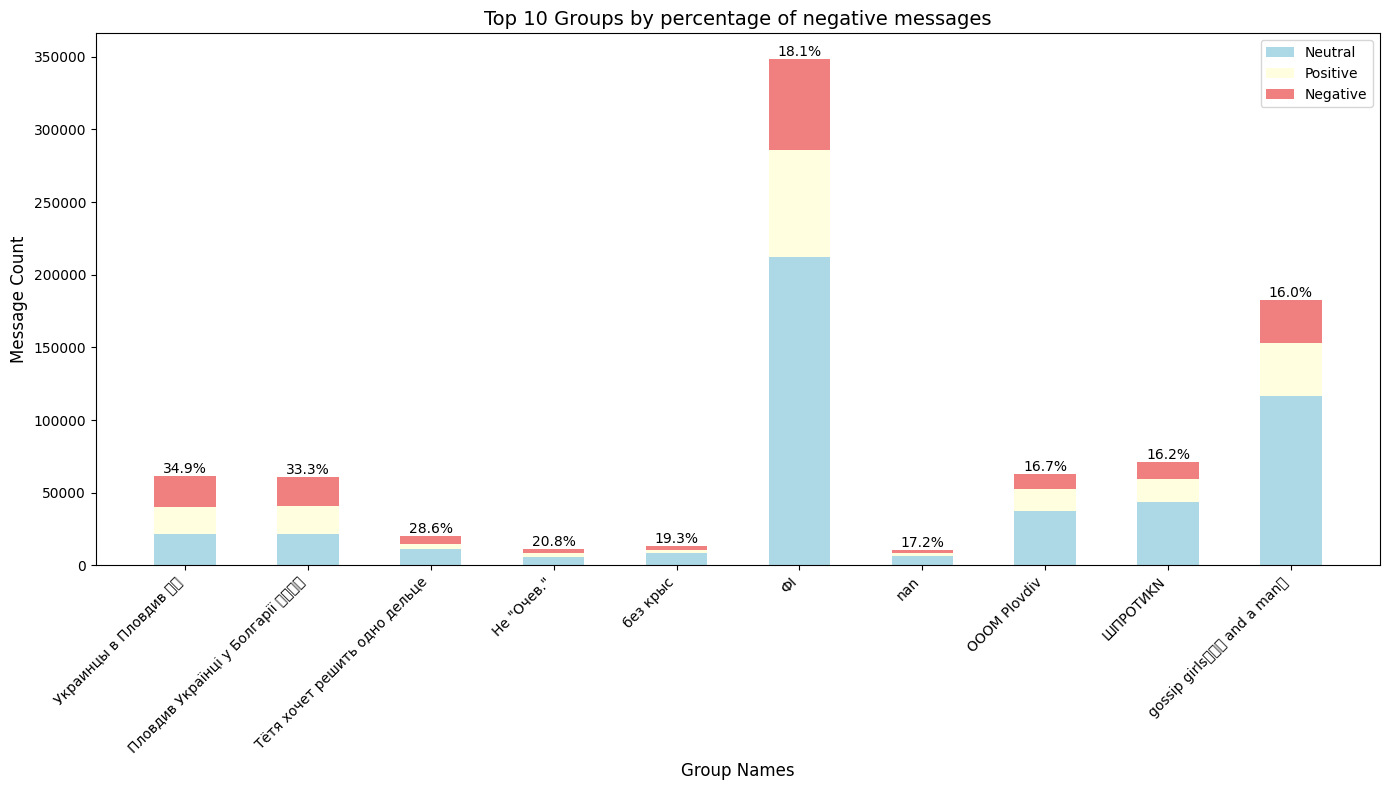

In [357]:
group_names = top_ngtv_perc['name']
negative = top_ngtv_perc['ngtv_count']
positive = top_ngtv_perc['pstv_count']
neutral = (
    top_ngtv_perc['total_count'] -
    top_ngtv_perc['pstv_count'] -
    top_ngtv_perc['ngtv_count']
)


fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.5
bar_positions = np.arange(len(group_names))

neutral_bars = ax.bar(bar_positions, neutral, bar_width, label='Neutral', color='lightblue')
positive_bars = ax.bar(bar_positions, positive, bar_width, label='Positive', color='lightyellow', bottom=neutral)
negative_bars = ax.bar(bar_positions, negative, bar_width, label='Negative', color='lightcoral', 
                        bottom=neutral + positive)

for i, bar in enumerate(negative_bars):
    total = neutral[i] + positive[i] + negative[i]
    percentage = (negative[i] / total) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + bar.get_y(), 
        f'{percentage:.1f}%', 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )

ax.set_xticks(bar_positions)
ax.set_xticklabels(group_names, rotation=45, ha='right', fontsize=10)
ax.set_xlabel('Group Names', fontsize=12)
ax.set_ylabel('Message Count', fontsize=12)
ax.set_title('Top 10 Groups by percentage of negative messages', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## Gender communication patterns

24. What is the gender distribution among users in the Telegram messenger?

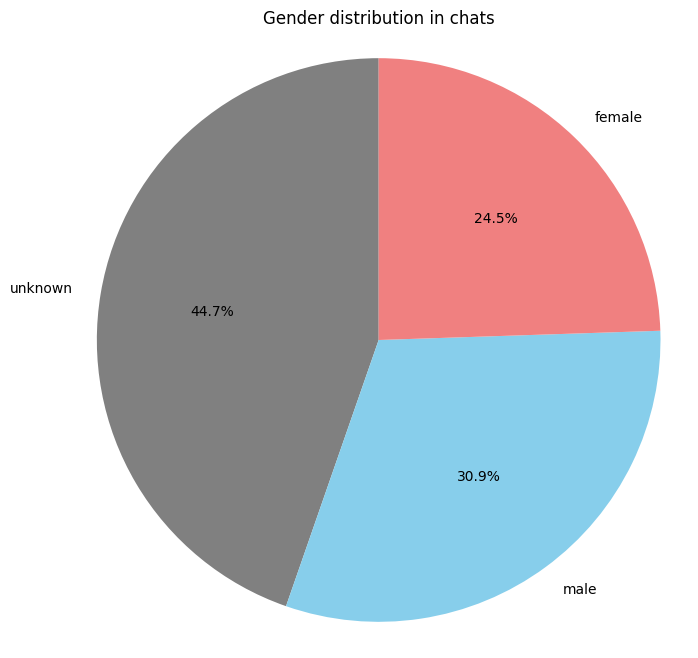

In [361]:
female_ukrainian = pd.read_csv("dicts/female_ukrainian_names.csv", header=None, names=["name"])
female_russian = pd.read_csv("dicts/female_russian_names.csv", header=None, names=["name"])
male_ukrainian = pd.read_csv("dicts/male_ukrainian_names.csv", header=None, names=["name"])
male_russian = pd.read_csv("dicts/male_russian_names.csv", header=None, names=["name"])
female_ru_ukr_trans = pd.read_csv("dicts/female_ru_ukr_trans_names.csv", header=None, names=["name"])
male_ru_ukr_trans = pd.read_csv("dicts/male_ru_ukr_trans_names.csv", header=None, names=["name"])

female_names = set(female_ukrainian['name'].str.lower().str.strip()).union(
    set(female_russian['name'].str.lower().str.strip()),
    set(female_ru_ukr_trans['name'].str.lower().str.strip())
)

male_names = set(male_ukrainian['name'].str.lower().str.strip()).union(
    set(male_russian['name'].str.lower().str.strip()),
    set(male_ru_ukr_trans['name'].str.lower().str.strip())
)

df_meta_copy = df_meta.copy()
df_meta_copy = df_meta_copy.drop_duplicates(subset=['users'])

def extract_first_name_directly(user_data):
    try:
        first_name = user_data.split("'first_name':")[1].split(",")[0].strip()
        return first_name.replace("'", "").lower()
    except (IndexError, AttributeError):
        return None

df_meta_copy['user_name'] = df_meta_copy['users'].apply(extract_first_name_directly)

df_meta_copy['first_name_clean'] = df_meta_copy['user_name'].str.lower().str.strip()

def determine_gender_by_substring(first_name):
    for female_name in female_names:
        if female_name in first_name:
            return "female"
    for male_name in male_names:
        if male_name in first_name:
            return "male"
    return "unknown"

df_meta_copy['gender'] = df_meta_copy['user_name'].apply(determine_gender_by_substring)
df_meta_copy.drop(columns=['first_name_clean'], inplace=True)
gender_counts = df_meta_copy['gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['grey', 'skyblue', 'lightcoral']
)
plt.title("Gender distribution in chats")
plt.axis('equal')
plt.show()

Who texts more men or women?

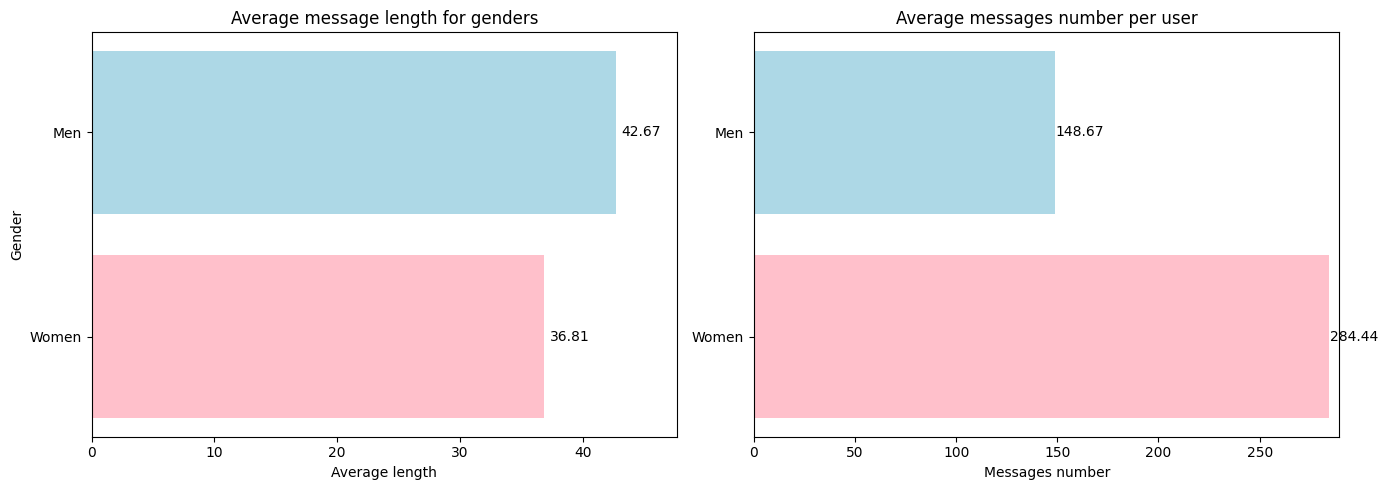

In [185]:
group_chats = df_copy[df_copy['dialog_id'].astype(str).str.contains('-')].copy()

men_messages = group_chats[group_chats['from_id'].astype(str).isin(men_ids)]
women_messages = group_chats[group_chats['from_id'].astype(str).isin(women_ids)]

male_users = len(men_messages['from_id'].unique())
female_users = len(women_messages['from_id'].unique())

male_messages_count = men_messages.shape[0]
female_messages_count = women_messages.shape[0]

average_per_male = male_messages_count / male_users if male_users > 0 else 0
average_per_female = female_messages_count / female_users if female_users > 0 else 0

women_messages = women_messages.assign(message_length=women_messages['message'].str.len().fillna(0))
men_messages = men_messages.assign(message_length=men_messages['message'].str.len().fillna(0))

average_lengths = {
    "Women": women_messages['message_length'].mean(),
    "Men": men_messages['message_length'].mean()
}

average_messages = {
    "Women": average_per_female,
    "Men": average_per_male
}

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bars1 = axs[0].barh(list(average_lengths.keys()), list(average_lengths.values()), color=['pink', 'lightblue'])
axs[0].set_title('Average message length for genders')
axs[0].set_xlabel('Average length')
axs[0].set_ylabel('Gender')
axs[0].set_xlim(0, max(average_lengths.values()) + 5)

for bar in bars1:
    axs[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", va='center')

bars2 = axs[1].barh(list(average_messages.keys()), list(average_messages.values()), color=['pink', 'lightblue'])
axs[1].set_title('Average messages number per user')
axs[1].set_xlabel('Messages number')
axs[1].set_xlim(0, max(average_messages.values()) + 5)

for bar in bars2:
    axs[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f"{bar.get_width():.2f}", va='center')
    
plt.tight_layout()
plt.show()

Women participate more actively in group chats on average than men, but write a bit shorter messages by char count.

Who use stickers more often in their messsages men or women?

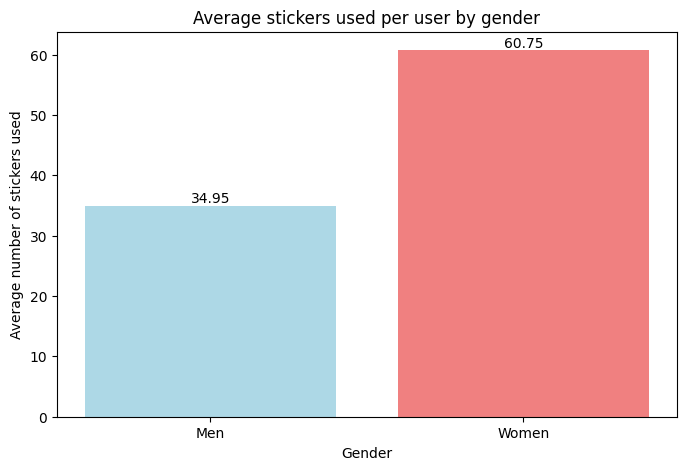

In [117]:
sticker_messages = df_copy[(df_copy['type'] == 'sticker') | (df_copy['message'].apply(lambda x: contains_sticker(x) if isinstance(x, str) else False))]

men_sticker = sticker_messages[sticker_messages['from_id'].astype(str).isin(men_ids)]
women_sticker = sticker_messages[sticker_messages['from_id'].astype(str).isin(women_ids)]

men_sticker = len(men_sticker['from_id'].unique())
women_sticker = len(women_sticker['from_id'].unique())

total_men_stickers = men_sticker.shape[0]
total_women_stickers = women_sticker.shape[0]

avg_men_stickers = total_men_stickers / men_sticker if men_sticker > 0 else 0
avg_women_stickers = total_women_stickers / women_sticker if women_sticker > 0 else 0

plt.figure(figsize=(8, 5))
categories = ['Men', 'Women']
avg_stickers = [avg_men_stickers, avg_women_stickers]
colors = ['lightblue', 'lightcoral']

bars = plt.bar(categories, avg_stickers, color=colors)
plt.title('Average stickers used per user by gender')
plt.ylabel('Average number of stickers used')
plt.xlabel('Gender')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.2f}", ha='center')

plt.show()

Now with close people i talk russian, as it also the language we use to speak in my family. And this situation other people has too, between each other in group chats for uni, for example, we still want to use Ukrainian and also start to use it more in personal chats/